# Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [2]:
import math
#import numpy as np
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [3]:
#These files are taken from examples/g2o.ipynb and examples/Helper Code.ipynb

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def nextPose(x, y, theta, delta_x, delta_y, delta_theta):
    x_next = x + delta_x * jnp.cos(theta) - delta_y * jnp.sin(theta)
    y_next = y + delta_y * jnp.cos(theta) + delta_x * jnp.sin(theta)
    theta_next = theta + delta_theta
    return jnp.array([x_next, y_next, theta_next])

def poses_to_string(poses):
    
    #Converting poses to string and defining it as per notation:
    posesString = []
    row=0
    for i in poses:
        s = "VERTEX_SE2"+" "+str(row)+" "+str(i[0])+" "+str(i[1])+" "+str(i[2])
        row+=1
        posesString.append(s)
    
    return posesString

In [4]:
#Read and store vertices(poses)
init_pose = readVertex("../data/edges.txt") #There is only one pose initially
init_pose = init_pose.reshape(1,-1)

#Read and store edges(odometry and loop-constraint)
ind1_arr,ind2_arr,del_x,del_y,del_theta = readEdge("../data/edges.txt")
edges = jnp.c_[ind1_arr,ind2_arr,del_x,del_y,del_theta]

poses = jnp.array(init_pose)
latest_pose = init_pose

#Traverse through all the edges and keep finding pose k+1 corresponding to edge k
for i in edges:

    #Ignore loop-constraint
    if i[0]+1!=i[1]:        
        continue

    x_k = latest_pose[0,0]
    y_k = latest_pose[0,1]
    theta_k = latest_pose[0,2]

    #Update according to motion model
    x_k1 = x_k + i[2]*jnp.cos(theta_k) - i[3]*jnp.sin(theta_k) 
    y_k1 = y_k + i[3]*jnp.cos(theta_k) + i[2]*jnp.sin(theta_k) 
    theta_k1 = theta_k + i[4]

    latest_pose = jnp.array([[x_k1,y_k1,theta_k1]])
    poses = jnp.vstack((poses,latest_pose))      #add row correspondint to (k+1)th pose 

print(jnp.shape(poses))
print(jnp.shape(edges))

(120, 3)
(139, 5)


In [5]:
#Now we will create and save the file edges-poses.txt
posesString = poses_to_string(poses)

#First deleting any previous occurence of the file
os.system('rm ../data/edges-poses.txt')

#After creating edges-poses.txt, append poses info to it.
for i in posesString:
    file_object = open("../data/edges-poses.txt", 'a')
    file_object.write(i)
    file_object.write('\n')
file_object.close()

#Now open and read edges.txt file (and ignore the initial VERTEX_SE2 row), then append edges.txt to edges-pose.txt
with open("../data/edges.txt", "r") as f:
    lines = f.readlines()
with open("../data/edges-poses.txt","a") as f:
    for line in lines:
        if line.strip("\n") != "VERTEX_SE2 0 -5.0 -8.0 0.0":
            f.write(line)

#Converting to g2o file
os.system('cp ../data/edges-poses.txt ../data/edges-poses.g2o')

0

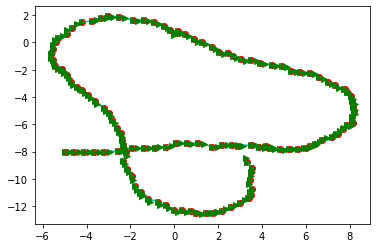

In [6]:
#Finally drawing:
draw(poses[:,0],poses[:,1],poses[:,2])

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [7]:
#Functions:

def residual(poses,edges,anchor):
    
    f_x = [poses[0,0]-anchor[0],poses[0,1]-anchor[1],poses[0,2]-anchor[2]]

    for edge in edges:
        #print("In RES")
        #print(edge)
        x = poses[int(edge[0]),0]
        y = poses[int(edge[0]),1]
        theta = poses[int(edge[0]),2]
        del_x = edge[2]
        del_y = edge[3]
        del_theta = edge[4]

        est = nextPose(x,y,theta,del_x,del_y,del_theta)
        
        f_x.append(est[0]-poses[int(edge[1]),0])
        f_x.append(est[1]-poses[int(edge[1]),1])
        f_x.append(est[2]-poses[int(edge[1]),2])

    return jnp.asarray(f_x)

def Jacobian_inbuilt(poses,edges,anchor):
    get_jacobian = jax.jacfwd(residual, argnums=0)
    J = get_jacobian(poses, edges, anchor)
    J = J.reshape((420, -1, 1))[:, :, 0]
    return J

def Information_Matrix(edges,informationOdometry,informationLoopConst,informationAnchor):

    diagonalEntries = [informationAnchor,informationAnchor,informationAnchor]

    for edge in edges:
        ##print("In IM")
        #print(edge)
        if edge[0]+1==edge[1]:
            diagonalEntries.append(informationOdometry)
            diagonalEntries.append(informationOdometry)
            diagonalEntries.append(informationOdometry)
        else:
            diagonalEntries.append(informationLoopConst)
            diagonalEntries.append(informationLoopConst)
            diagonalEntries.append(informationLoopConst)
    
    infoMatrix = jnp.diag(jnp.array(diagonalEntries))
    return infoMatrix

def get_error(poses, edges, anchor, informationMatrix):
    res = residual(poses, edges, anchor)
    error = 0.5 * res.T @ informationMatrix @ res
    return error

In [8]:
def Jacobian_Analytical(poses,edges,anchor):

    dim1 = 3*jnp.shape(edges)[0]+3   
    dim2 = 3*jnp.shape(poses)[0]

    J = jnp.zeros((dim1,dim2))    

    #Updating Jacobian w.r.t Anchor 
    J = J.at[0,0].set(1)      #w.r.t. x0
    J = J.at[1,1].set(1)      #w.r.t. y0
    J = J.at[2,2].set(1)     #w.r.t. theta_0

    for rows in range(jnp.shape(edges)[0]):
        
        edge = edges[rows]
        
        theta_i = poses[int(edge[0]),2]
        del_x = edge[2]
        del_y = edge[3]
        del_theta = edge[4]
        
        i, j = int(edge[0]), int(edge[1])
        J_row = 3*rows+3

        #Updating Jacobian w.r.t i_th pose:
        J_column_i = 3*i      #First Column corresponding to pose 'i'       
        J = J.at[J_row,J_column_i].set(1)                           #Updating x_i
        J = J.at[J_row+1,J_column_i+1].set(1)                       #Updating y_i
        J = J.at[J_row+2,J_column_i+2].set(1)                       #Updating theta_i    
        J = J.at[J_row,J_column_i+2].set(-del_x*jnp.sin(theta_i) - del_y*jnp.cos(theta_i))   #Updating theta_i
        J = J.at[J_row+1,J_column_i+2].set(-del_y*jnp.sin(theta_i) + del_x*jnp.cos(theta_i))   #Updating theta_i

        #Updating Jacobian w.r.t j_th pose:
        J_column_j = 3*j      #First Column corresponding to pose 'j'       
        J = J.at[J_row,J_column_j].set(-1)                          #Updating x_j
        J = J.at[J_row+1,J_column_j+1].set(-1)                          #Updating y_j
        J = J.at[J_row+2,J_column_j+2].set(-1)                          #Updating theta_j

    return J

In [9]:
#In this code we only update the Jacobian Matrix as we have shown that most of the values of J is constant and we know by sparsity that J will be mostly zero.
#Only updates will be because of theta_i

def Jacobian_Analytical_update_only(J,poses,edges,anchor):

    for rows in range(jnp.shape(edges)[0]):
        
        edge = edges[rows]
        
        theta_i = poses[int(edge[0]),2]
        del_x = edge[2]
        del_y = edge[3]
        
        i = int(edge[0])
        J_row = 3*rows+3

        #Updating Jacobian w.r.t i_th pose:
        J_column_i = 3*i      #First Column corresponding to pose 'i'           
        J = J.at[J_row,J_column_i+2].set(-del_x*jnp.sin(theta_i) - del_y*jnp.cos(theta_i))   #Updating theta_i
        J = J.at[J_row+1,J_column_i+2].set(-del_y*jnp.sin(theta_i) + del_x*jnp.cos(theta_i))   #Updating theta_i
    return J

In [23]:
def draw_all(X,Y,THETA):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax = plt.subplot(111)

    #Initial draw:
    initialPose = readVertex('../data/edges-poses.txt').T
    x_initial = initialPose[:,0]
    y_initial = initialPose[:,1]
    theta_initial = initialPose[:,2]
    
    ax.plot(x_initial, y_initial, 'ro')
    plt.plot(x_initial, y_initial, 'c-')
    for i in range(len(theta_initial)):
        x2 = 0.25*math.cos(theta_initial[i]) + x_initial[i]
        y2 = 0.25*math.sin(theta_initial[i]) + y_initial[i]
        plt.plot([x_initial[i], x2], [y_initial[i], y2], 'r->')

    
    #Ground Truth draw:
    gtPose = readVertex('../data/gt.txt').T
    
    x_gt = gtPose[:,0]
    y_gt = gtPose[:,1]
    theta_gt = gtPose[:,2]
    
    ax.plot(x_gt, y_gt, 'ro')
    plt.plot(x_gt, y_gt, 'c-')
    for i in range(len(theta_gt)):
        x2 = 0.25*math.cos(theta_gt[i]) + x_gt[i]
        y2 = 0.25*math.sin(theta_gt[i]) + y_gt[i]
        plt.plot([x_gt[i], x2], [y_gt[i], y2], 'k->')

    
    #Current pose draw:
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'c->')
    
    red = mpatches.Patch(color='red', label='Initial Pose')
    blue = mpatches.Patch(color='black', label='Ground Truth')
    green = mpatches.Patch(color='cyan', label='Current Pose')
    plt.legend(handles=[blue,red,green])
    plt.show()


In [52]:
def LM(poses, edges, anchor, lm_lambda, tolerance, iterations, informationValues,display_step = 10):
    
    prev_poses = poses
    past_poses = [prev_poses]

    informationOdometry = informationValues[0]
    informationLoopConst = informationValues[1]
    informationAnchor = informationValues[2]
    informationMatrix = Information_Matrix(edges,informationOdometry,informationLoopConst,informationAnchor)
    
    past_errors = [get_error(prev_poses, edges, anchor, informationMatrix)]
    #draw_all(prev_poses[:, 0], prev_poses[:, 1], prev_poses[:, 2])

    for itr in range(1, iterations + 1):

        res = residual(prev_poses, edges, anchor)
        
        if (itr==1):
            J =  Jacobian_Analytical(prev_poses, edges,anchor)
        else: 
            J = Jacobian_Analytical_update_only(J,prev_poses,edges,anchor)

        H = J.T @ informationMatrix @ J + lm_lambda * jnp.eye(J.shape[1])
        b = J.T @ informationMatrix.T @ res
        delta_poses = -jnp.linalg.inv(H) @ b
        delta_poses=delta_poses.reshape((-1,3))        
        
        cur_poses = prev_poses + delta_poses

        cur_error = get_error(cur_poses, edges, anchor, informationMatrix)
        print("The error value for interation ", itr, " came out to be : ", cur_error, "\n")

        #if itr % display_step == 0 or itr == iterations:
        draw_all(cur_poses[:, 0], cur_poses[:,1],cur_poses[:,2])
        
        if itr > 1:
            if cur_error > past_errors[-1]:
                lm_lambda *= 2
            else:
                lm_lambda /= 3

        cur_change = jnp.linalg.norm(cur_poses - prev_poses)

        if cur_change < tolerance:
            break

        past_poses.append(cur_poses)
        past_errors.append(cur_error)
        prev_poses = cur_poses
            
    return past_poses, past_errors

## Comparing Jacobians:

In [12]:
#Comparing Jacobian Analytical(calculated by us) vs Jacobian using jax()
anchor = poses[0, :]

J_inbuilt = Jacobian_inbuilt(poses,edges,anchor)
J_Analytical = Jacobian_Analytical(poses,edges,anchor)

Sum of absolute differences of values in Jacobian we get calculated and Jacobian obtained using inbuilt function = 0.0
Frobenius norm is =  0.0


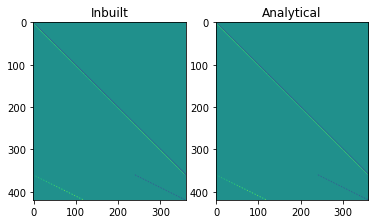

In [13]:
print("Sum of absolute differences of values in Jacobian we get calculated \
and Jacobian obtained using inbuilt function =",jnp.sum(abs(J_Analytical-J_inbuilt)))

frobNorm = jnp.linalg.norm(J_inbuilt - J_Analytical, 'fro')
print(f"Frobenius norm is = ",frobNorm)

fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(J_inbuilt)
ax1.set_title('Inbuilt')
ax2.imshow(J_Analytical)
ax2.set_title('Analytical')
plt.show()

## Running the LM(Levenberg-Marquardt) alorithm for Pose Graph Optimisation

### Running for information values : (10,1000,1000)

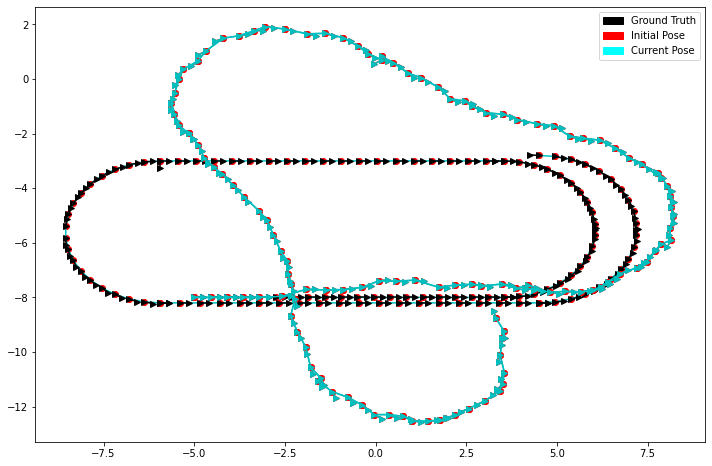

The error value for interation  1  came out to be :  160264.6 



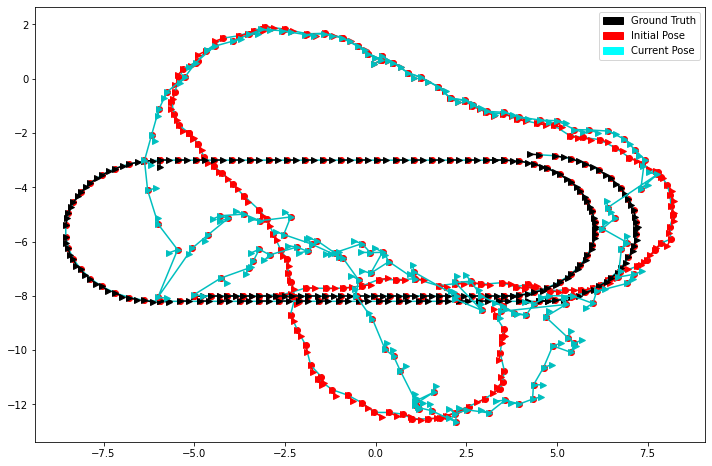

The error value for interation  2  came out to be :  439.68478 



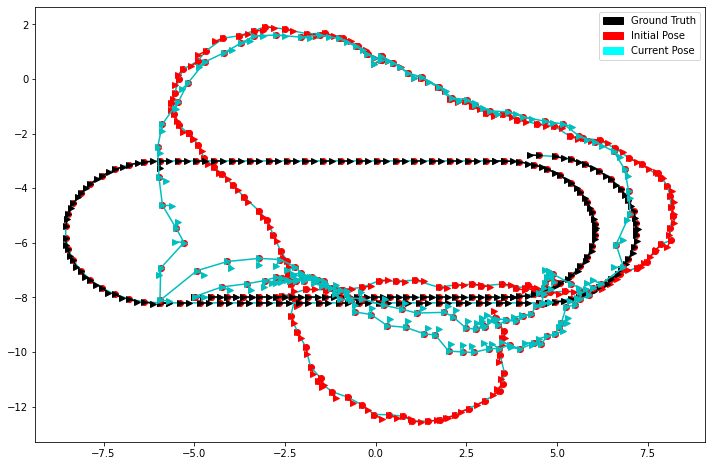

The error value for interation  3  came out to be :  417.11737 



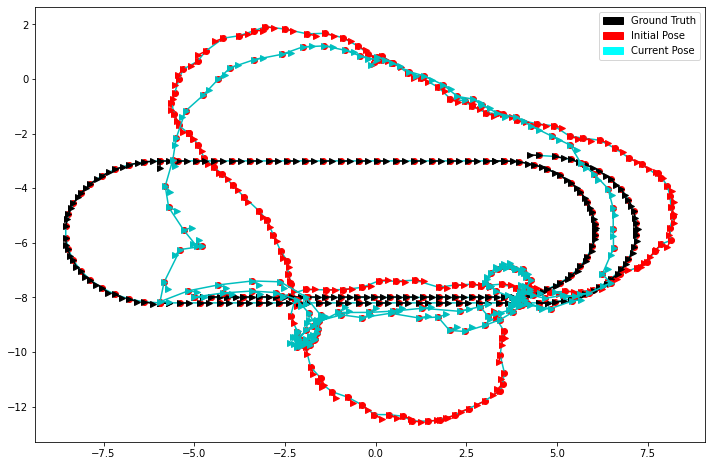

The error value for interation  4  came out to be :  99.55373 



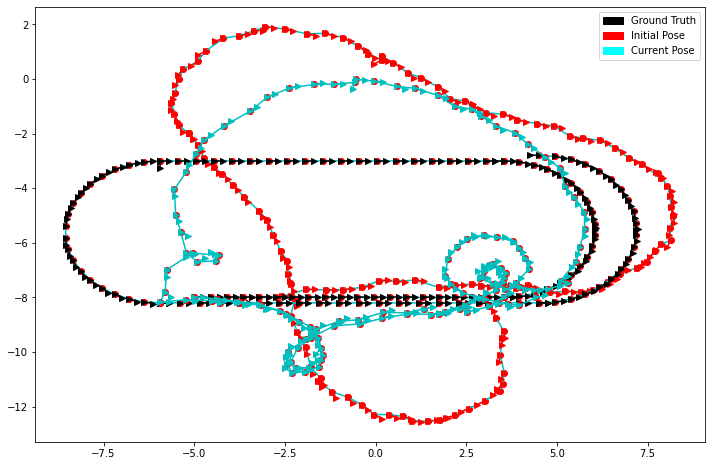

The error value for interation  5  came out to be :  74.08875 



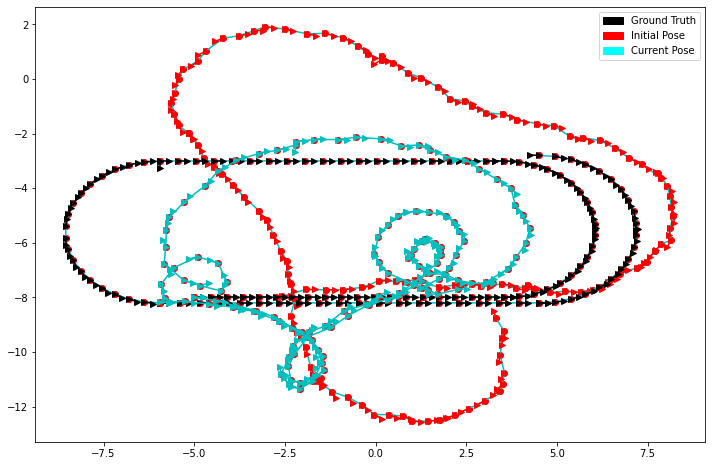

The error value for interation  6  came out to be :  90.64276 



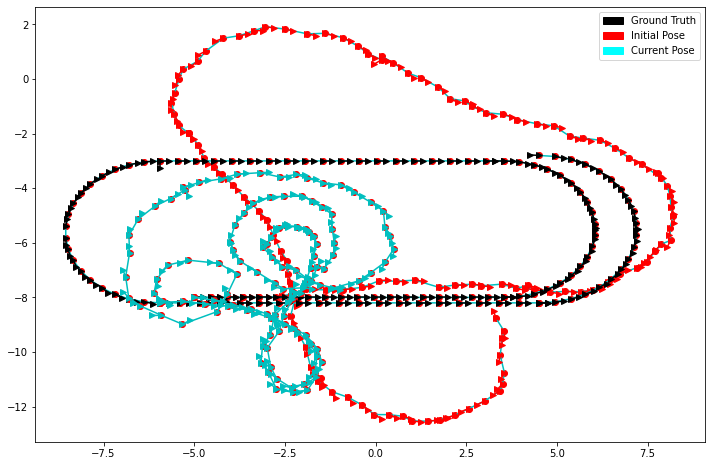

The error value for interation  7  came out to be :  39.75722 



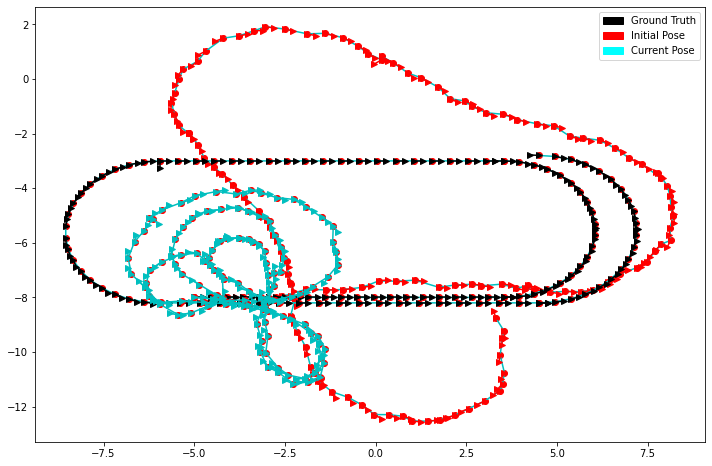

The error value for interation  8  came out to be :  111.38565 



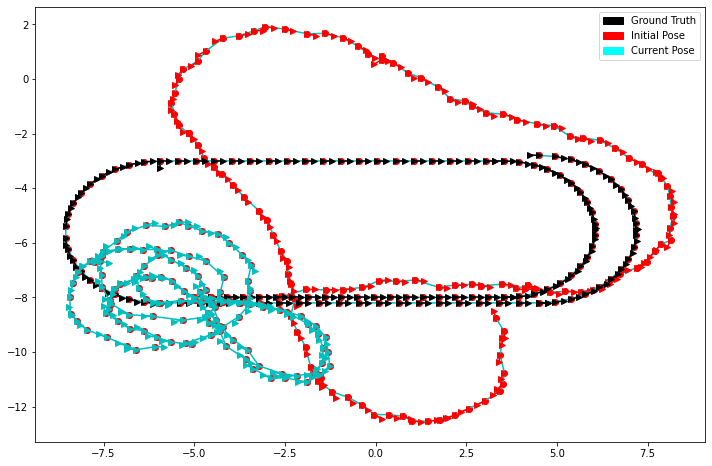

The error value for interation  9  came out to be :  30.372276 



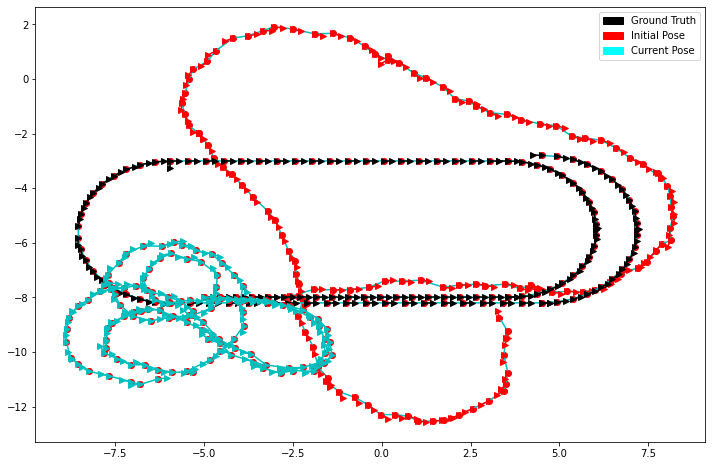

The error value for interation  10  came out to be :  72.92606 



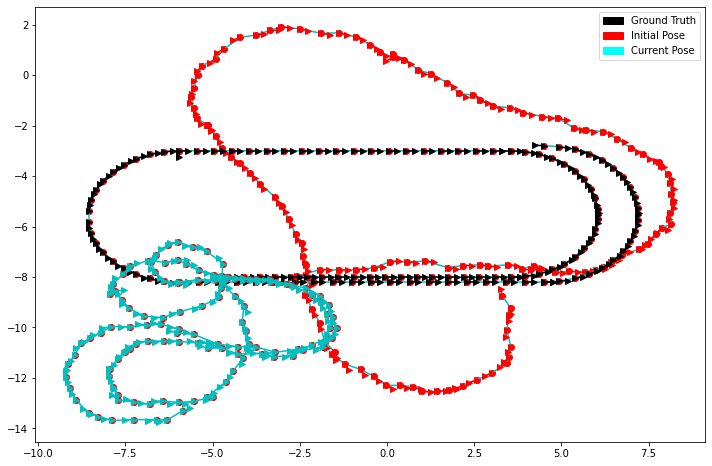

The error value for interation  11  came out to be :  28.616873 



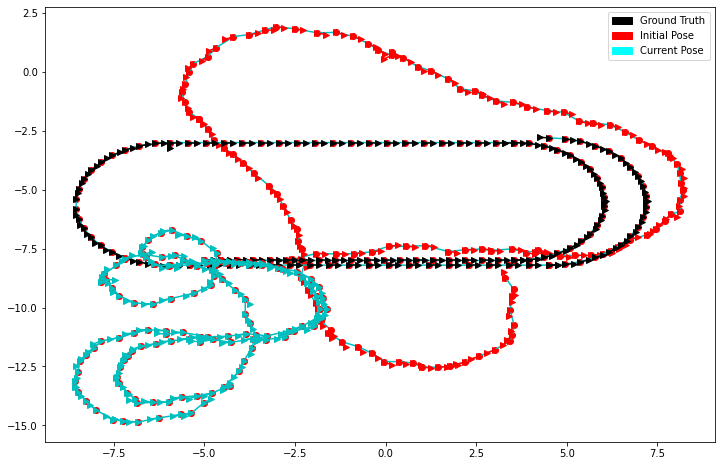

The error value for interation  12  came out to be :  82.13957 



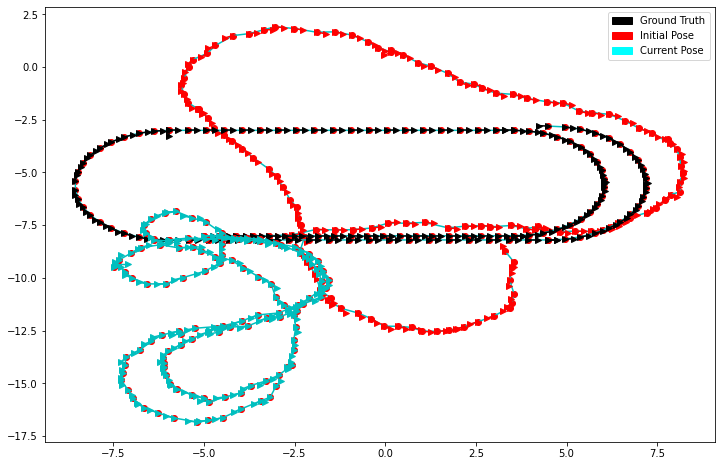

The error value for interation  13  came out to be :  29.048155 



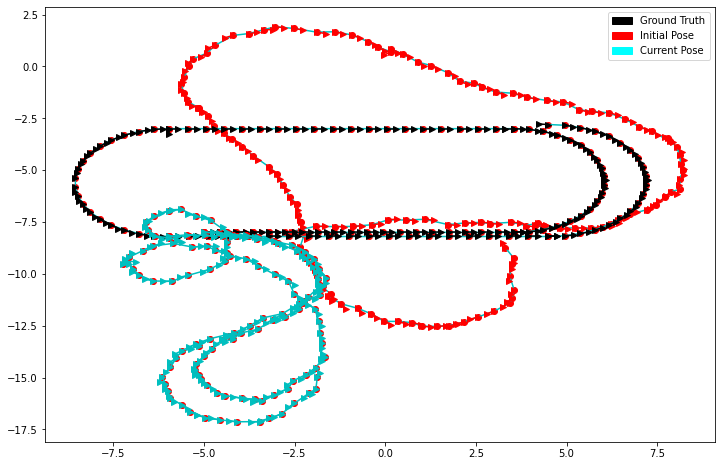

The error value for interation  14  came out to be :  93.69395 



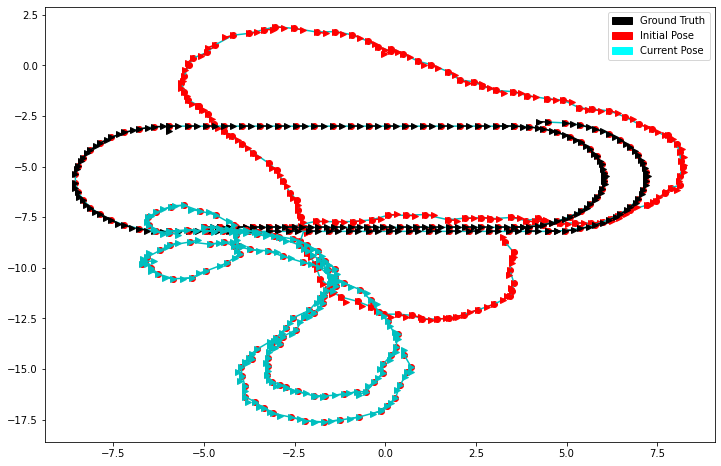

The error value for interation  15  came out to be :  26.34442 



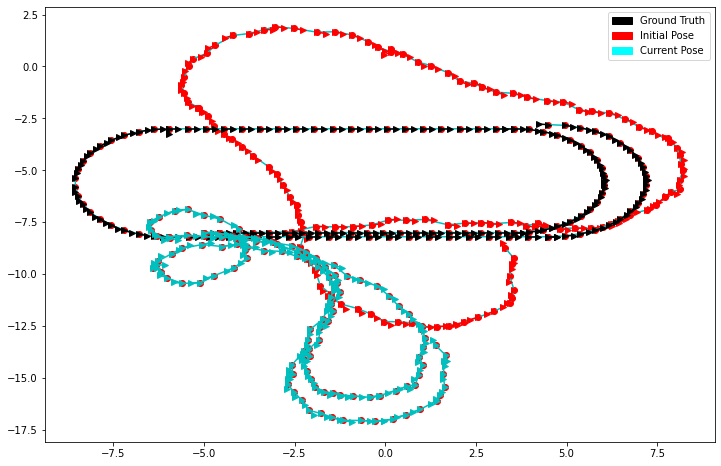

The error value for interation  16  came out to be :  85.04761 



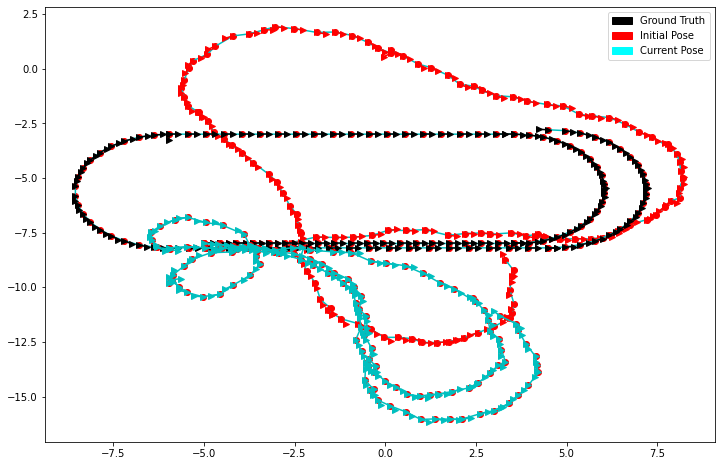

The error value for interation  17  came out to be :  20.985683 



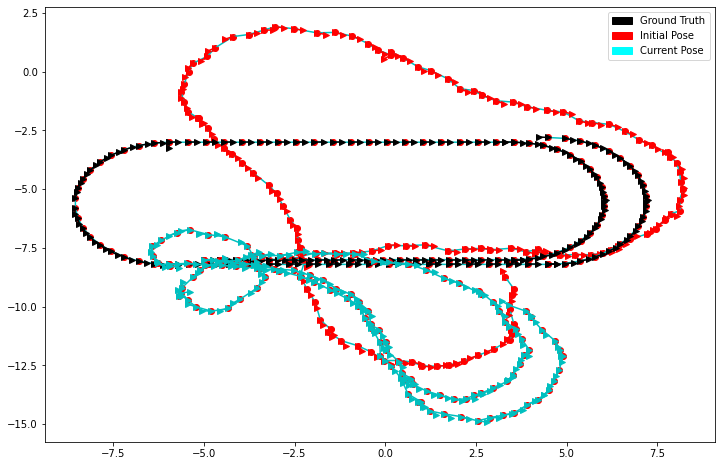

The error value for interation  18  came out to be :  59.36056 



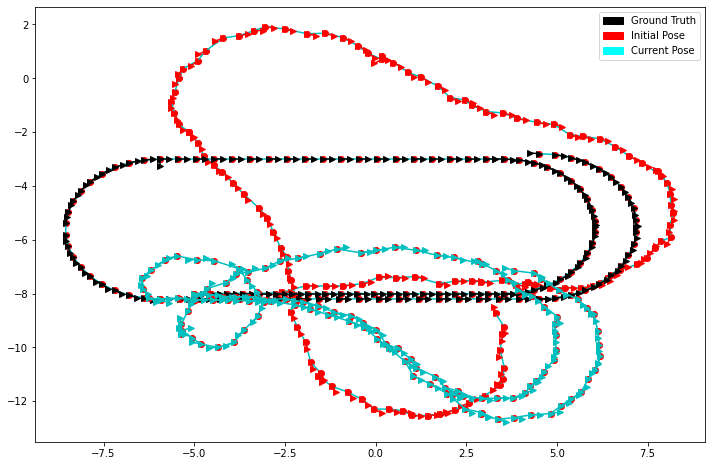

The error value for interation  19  came out to be :  15.563348 



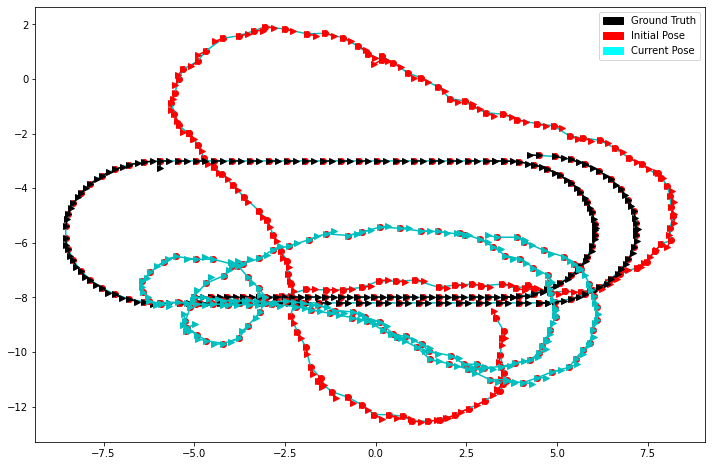

The error value for interation  20  came out to be :  30.878063 



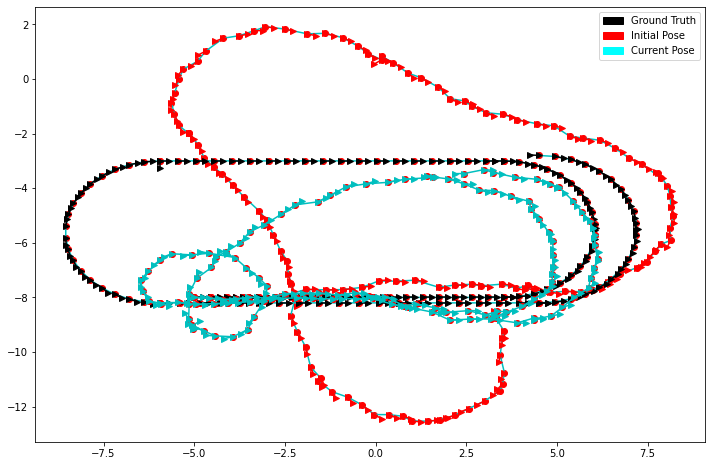

The error value for interation  21  came out to be :  11.969321 



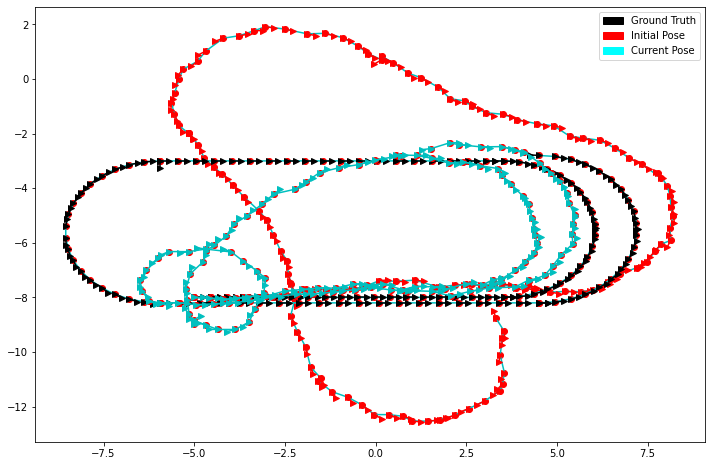

The error value for interation  22  came out to be :  14.882297 



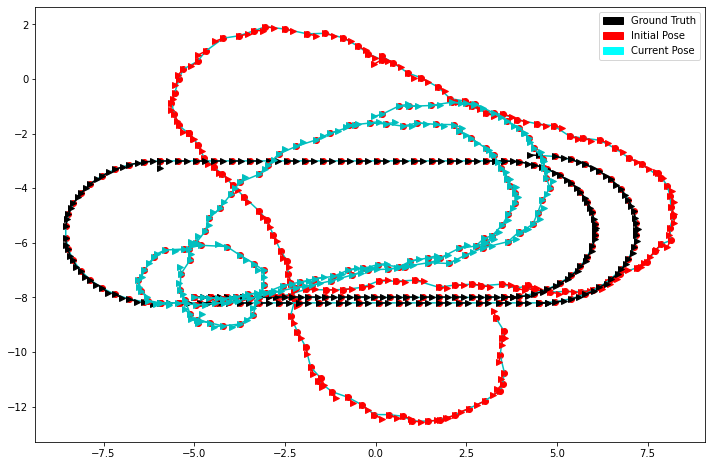

The error value for interation  23  came out to be :  10.277706 



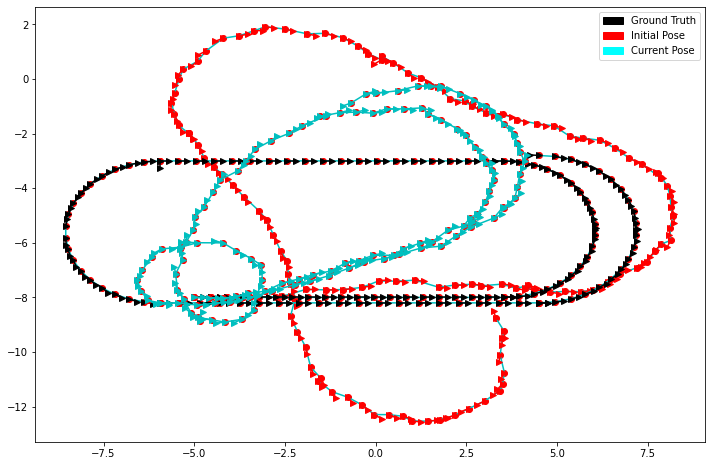

The error value for interation  24  came out to be :  10.437672 



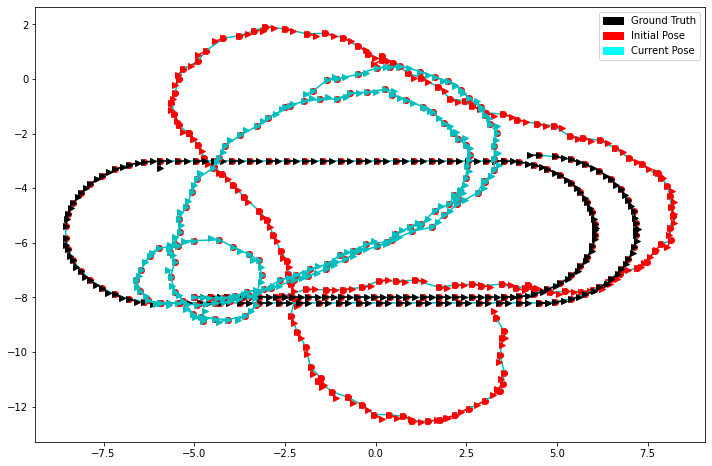

The error value for interation  25  came out to be :  9.781141 



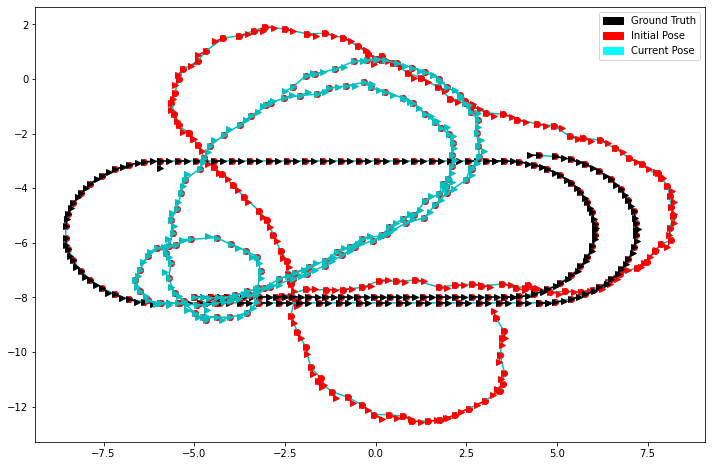

The error value for interation  26  came out to be :  9.746513 



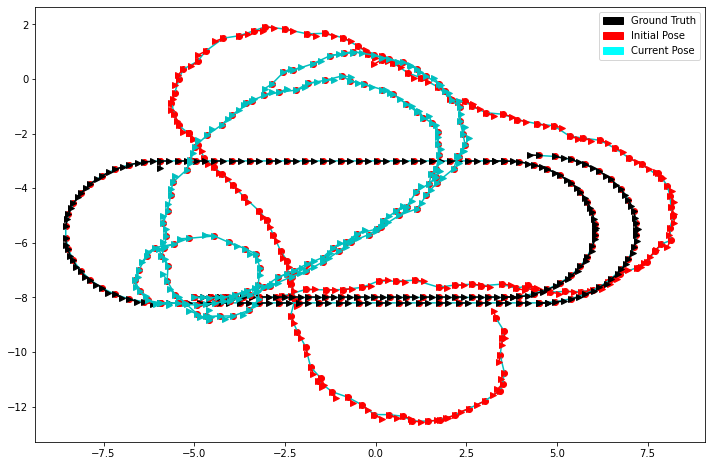

The error value for interation  27  came out to be :  9.6895 



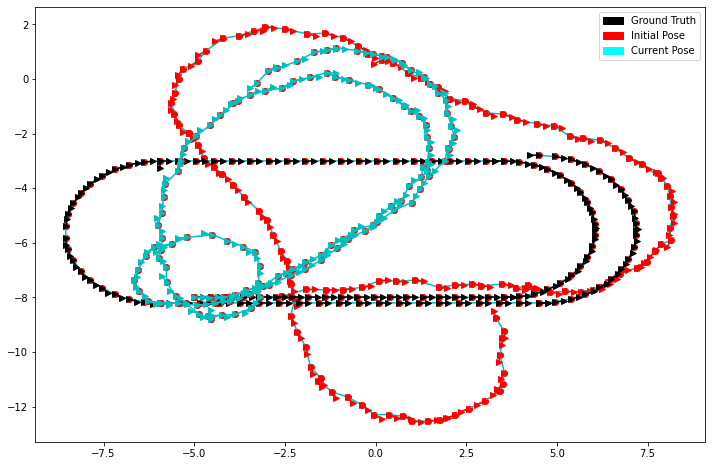

The error value for interation  28  came out to be :  9.672977 



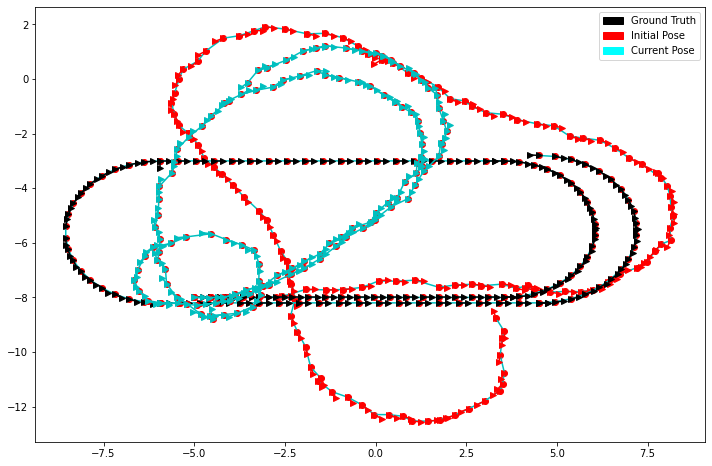

The error value for interation  29  came out to be :  9.667738 



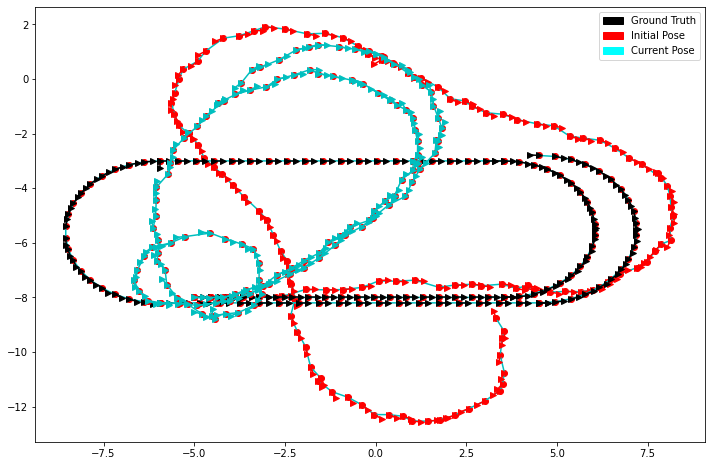

The error value for interation  30  came out to be :  9.666006 



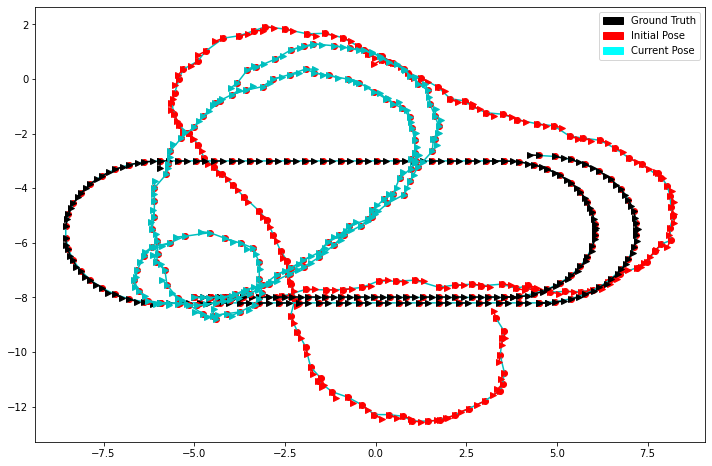

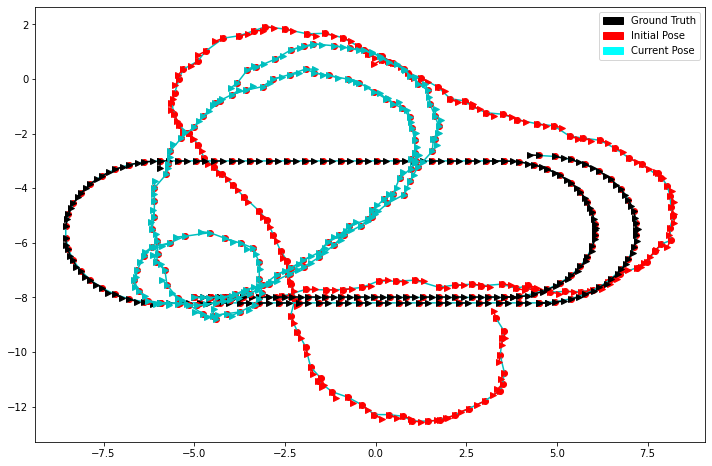

In [53]:
# Initial information values:
informationOdometry = 10
informationLoopConst = 1000
informationAnchor = 1000
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 30
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

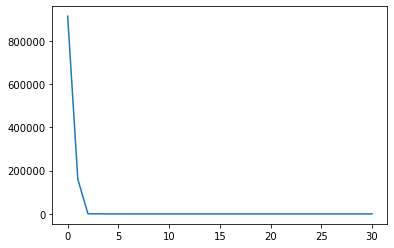

In [54]:
plt.plot(collection_errors)

### Running for information values : (500,700,1000)

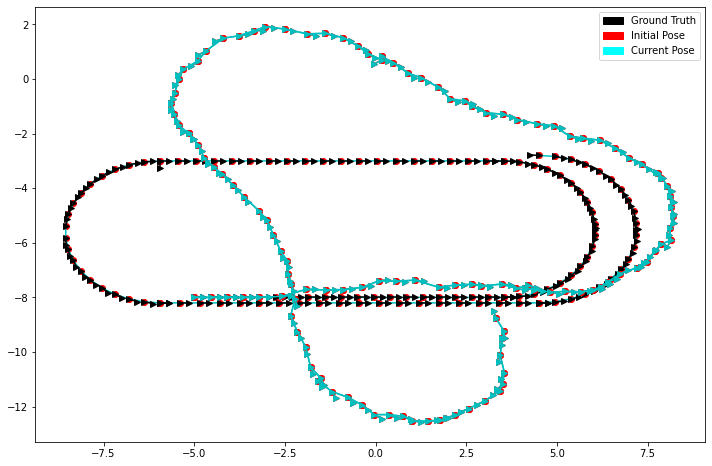

The error value for interation  1  came out to be :  90723.516 

The error value for interation  2  came out to be :  5202.1685 

The error value for interation  3  came out to be :  3779.434 

The error value for interation  4  came out to be :  2082.3232 

The error value for interation  5  came out to be :  1438.3513 

The error value for interation  6  came out to be :  1189.6788 

The error value for interation  7  came out to be :  1065.8604 

The error value for interation  8  came out to be :  666.7503 

The error value for interation  9  came out to be :  527.5359 

The error value for interation  10  came out to be :  465.17892 



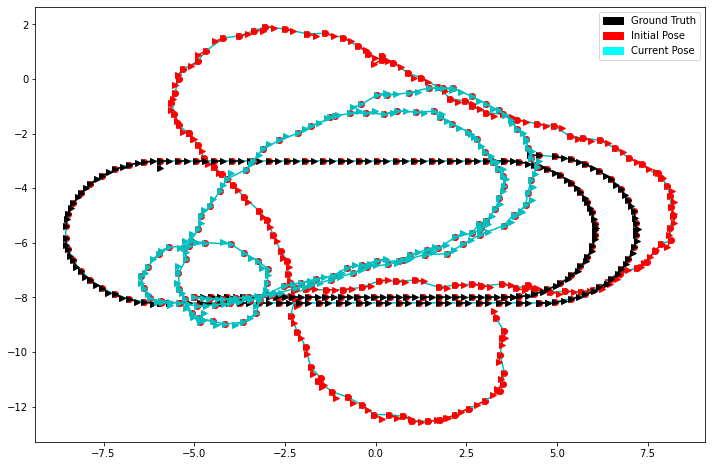

The error value for interation  11  came out to be :  451.29648 

The error value for interation  12  came out to be :  446.84576 

The error value for interation  13  came out to be :  445.43842 

The error value for interation  14  came out to be :  444.91754 

The error value for interation  15  came out to be :  444.71527 

The error value for interation  16  came out to be :  444.6336 

The error value for interation  17  came out to be :  444.59995 

The error value for interation  18  came out to be :  444.5865 

The error value for interation  19  came out to be :  444.58035 

The error value for interation  20  came out to be :  444.5779 



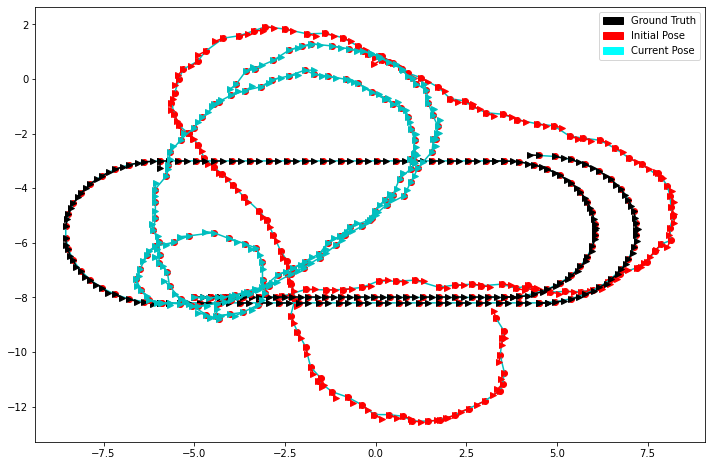

The error value for interation  21  came out to be :  444.57742 

The error value for interation  22  came out to be :  444.5765 

The error value for interation  23  came out to be :  444.5764 

The error value for interation  24  came out to be :  444.5762 

The error value for interation  25  came out to be :  444.57663 

The error value for interation  26  came out to be :  444.57675 

The error value for interation  27  came out to be :  444.57602 

The error value for interation  28  came out to be :  444.57642 

The error value for interation  29  came out to be :  444.57623 

The error value for interation  30  came out to be :  444.57623 



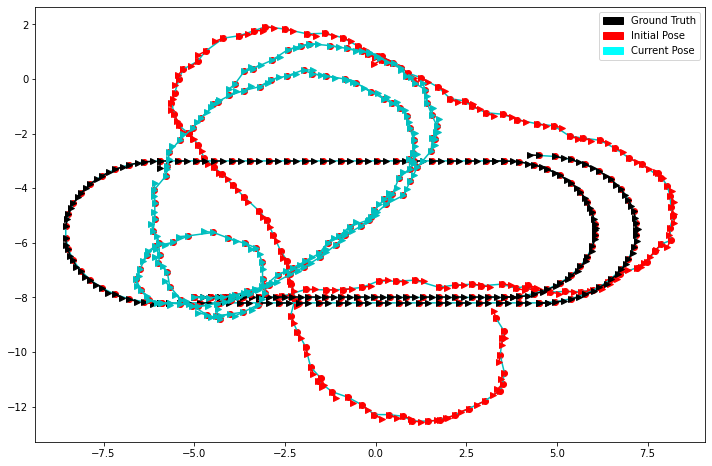

The error value for interation  31  came out to be :  444.57608 

The error value for interation  32  came out to be :  444.57587 

The error value for interation  33  came out to be :  444.57605 

The error value for interation  34  came out to be :  444.57623 

The error value for interation  35  came out to be :  444.57635 

The error value for interation  36  came out to be :  444.57645 

The error value for interation  37  came out to be :  444.5763 

The error value for interation  38  came out to be :  444.5763 

The error value for interation  39  came out to be :  444.57645 

The error value for interation  40  came out to be :  444.57642 



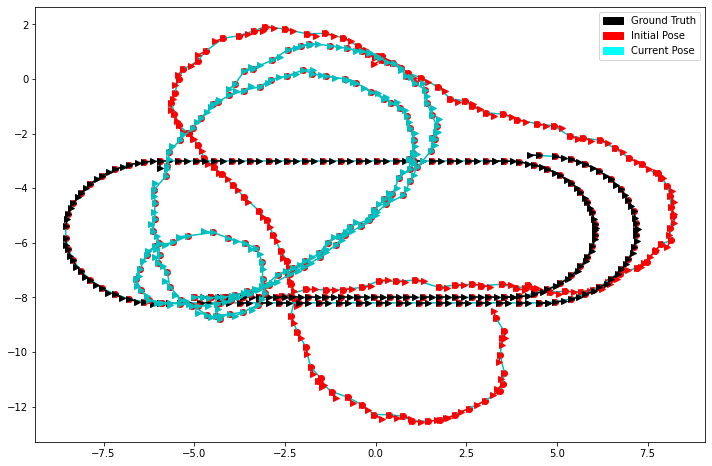

The error value for interation  41  came out to be :  444.5764 

The error value for interation  42  came out to be :  444.57626 

The error value for interation  43  came out to be :  444.5764 



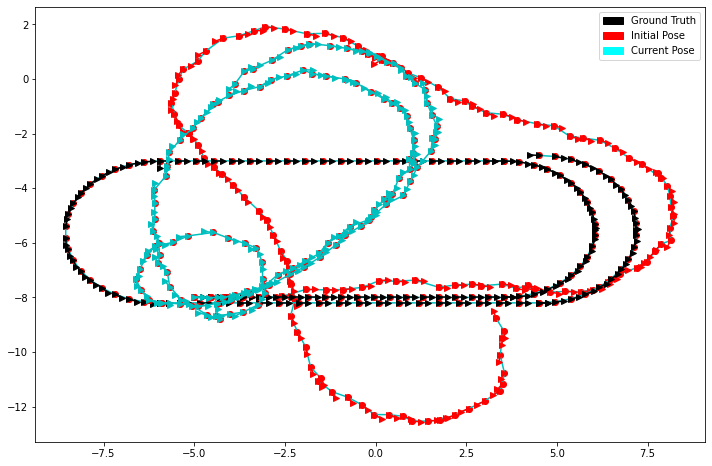

In [41]:
# Initial information values:
informationOdometry = 500
informationLoopConst = 700
informationAnchor = 1000
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 50
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

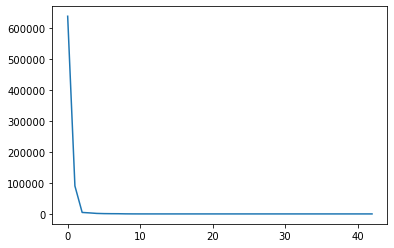

In [42]:
plt.plot(collection_errors)

### Running for information values : (600,20,10)

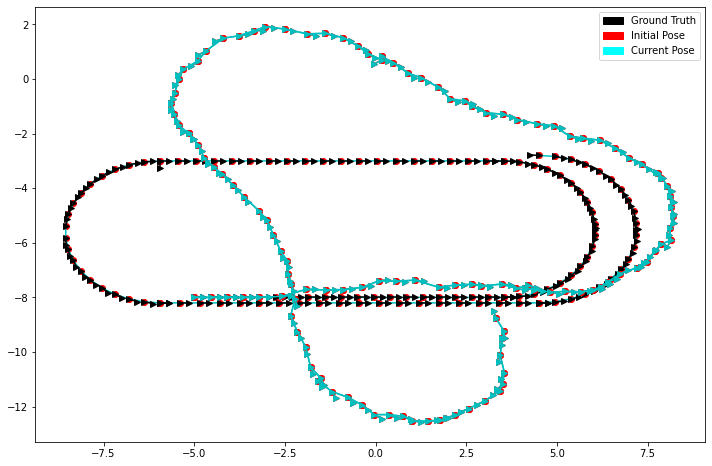

The error value for interation  1  came out to be :  8550.489 

The error value for interation  2  came out to be :  5728.454 

The error value for interation  3  came out to be :  5217.889 

The error value for interation  4  came out to be :  4311.33 

The error value for interation  5  came out to be :  3645.8425 

The error value for interation  6  came out to be :  3350.9294 

The error value for interation  7  came out to be :  3037.9001 

The error value for interation  8  came out to be :  2701.3743 

The error value for interation  9  came out to be :  2326.696 

The error value for interation  10  came out to be :  1795.0364 



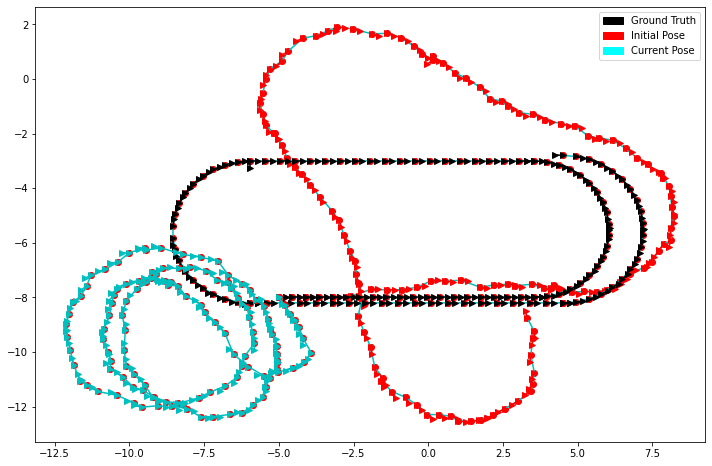

The error value for interation  11  came out to be :  1401.2434 

The error value for interation  12  came out to be :  549.1853 

The error value for interation  13  came out to be :  481.05524 

The error value for interation  14  came out to be :  453.59808 

The error value for interation  15  came out to be :  439.6513 

The error value for interation  16  came out to be :  446.75317 

The error value for interation  17  came out to be :  427.6187 

The error value for interation  18  came out to be :  450.5933 

The error value for interation  19  came out to be :  421.88074 

The error value for interation  20  came out to be :  477.69318 



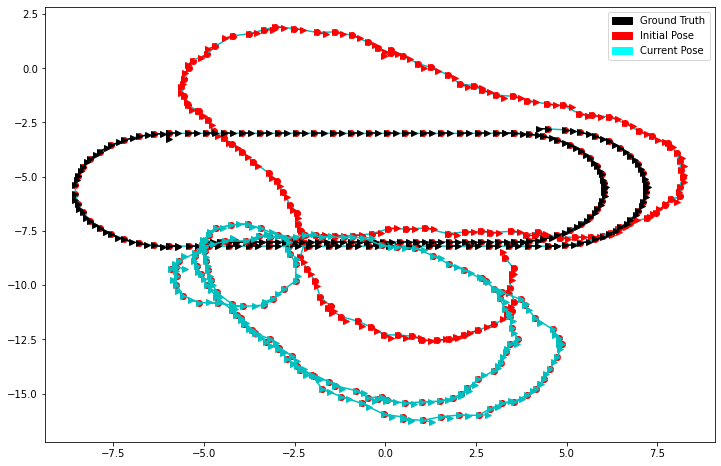

The error value for interation  21  came out to be :  424.88162 

The error value for interation  22  came out to be :  574.5792 

The error value for interation  23  came out to be :  495.10654 

The error value for interation  24  came out to be :  845.6033 

The error value for interation  25  came out to be :  825.6059 

The error value for interation  26  came out to be :  1385.8206 

The error value for interation  27  came out to be :  1429.8779 

The error value for interation  28  came out to be :  2148.2327 

The error value for interation  29  came out to be :  1885.7938 

The error value for interation  30  came out to be :  2939.5908 



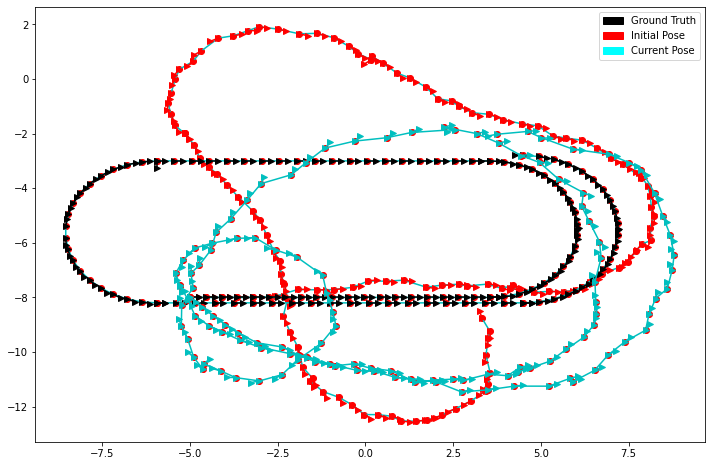

The error value for interation  31  came out to be :  2035.8052 

The error value for interation  32  came out to be :  3456.655 

The error value for interation  33  came out to be :  2095.642 

The error value for interation  34  came out to be :  3633.1074 

The error value for interation  35  came out to be :  2176.1765 

The error value for interation  36  came out to be :  3589.128 

The error value for interation  37  came out to be :  2270.3503 

The error value for interation  38  came out to be :  3475.5164 

The error value for interation  39  came out to be :  2361.7168 

The error value for interation  40  came out to be :  3343.0686 



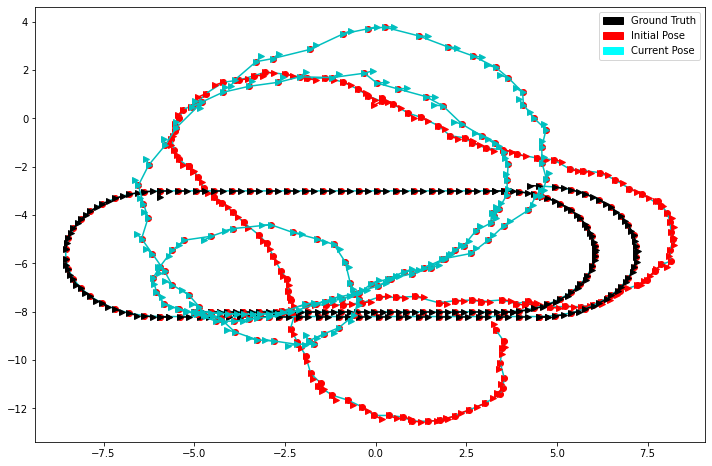

The error value for interation  41  came out to be :  2440.0334 

The error value for interation  42  came out to be :  3237.8237 

The error value for interation  43  came out to be :  2500.4448 

The error value for interation  44  came out to be :  3147.707 

The error value for interation  45  came out to be :  2553.7922 

The error value for interation  46  came out to be :  3077.1636 

The error value for interation  47  came out to be :  2592.996 

The error value for interation  48  came out to be :  3027.9495 

The error value for interation  49  came out to be :  2624.8442 

The error value for interation  50  came out to be :  2987.4153 



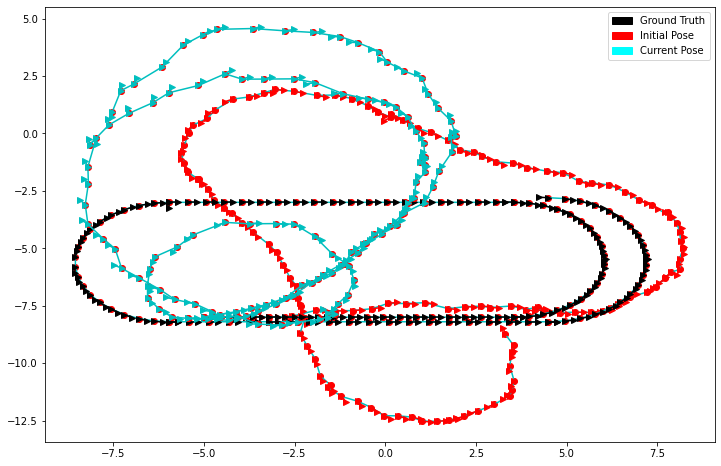

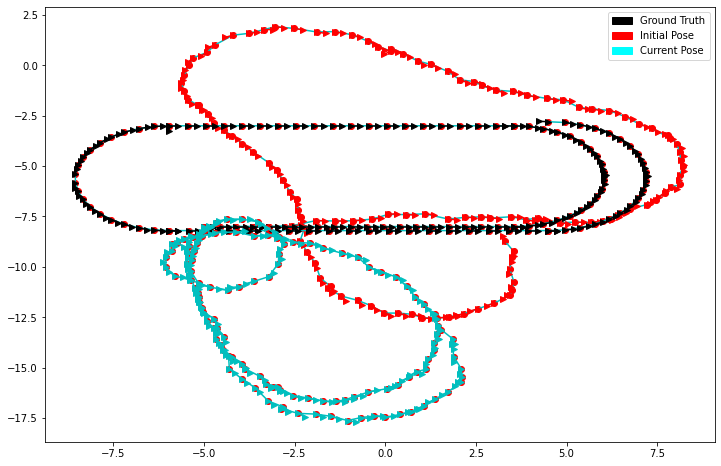

In [43]:
# Initial information values:
informationOdometry = 600
informationLoopConst = 20
informationAnchor = 10
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 50
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

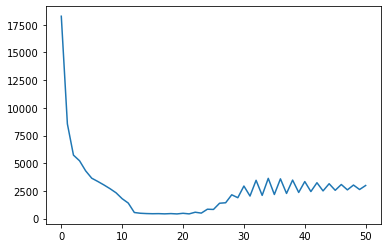

In [44]:
plt.plot(collection_errors)

### Running for information values : (1,100,100)

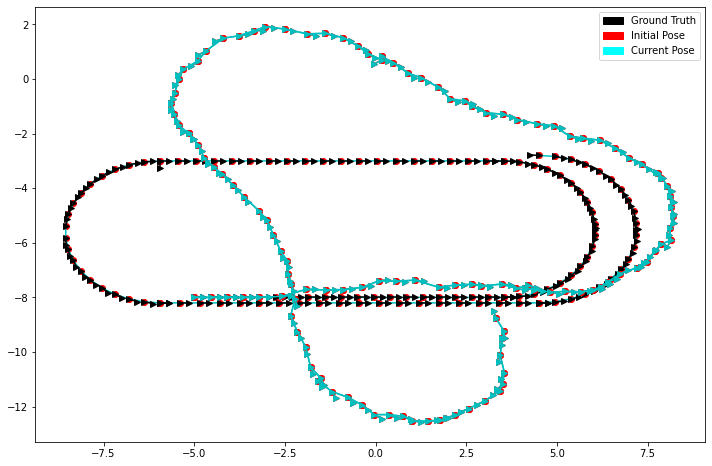

The error value for interation  1  came out to be :  18837.355 

The error value for interation  2  came out to be :  95.79939 

The error value for interation  3  came out to be :  43.954144 

The error value for interation  4  came out to be :  32.233143 

The error value for interation  5  came out to be :  33.125458 

The error value for interation  6  came out to be :  14.265118 

The error value for interation  7  came out to be :  9.686558 

The error value for interation  8  came out to be :  7.041814 

The error value for interation  9  came out to be :  6.1978664 

The error value for interation  10  came out to be :  14.264142 



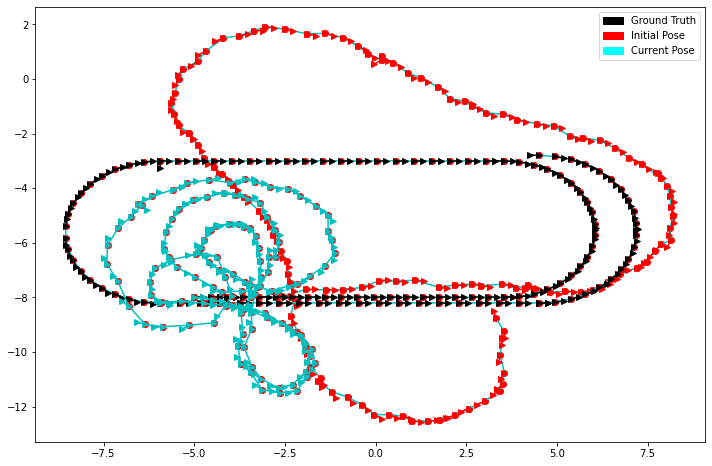

The error value for interation  11  came out to be :  3.7408686 

The error value for interation  12  came out to be :  10.978765 

The error value for interation  13  came out to be :  2.9320052 

The error value for interation  14  came out to be :  8.202774 

The error value for interation  15  came out to be :  3.036735 

The error value for interation  16  came out to be :  9.830143 

The error value for interation  17  came out to be :  3.0039942 

The error value for interation  18  came out to be :  10.266152 

The error value for interation  19  came out to be :  2.5287225 

The error value for interation  20  came out to be :  7.9988103 



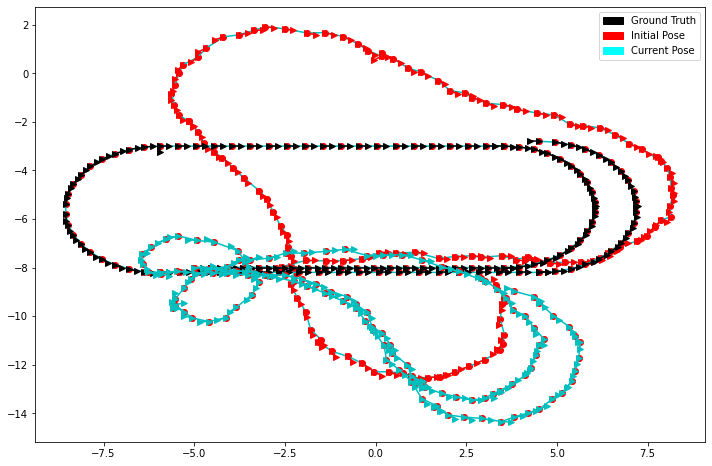

The error value for interation  21  came out to be :  1.8533105 

The error value for interation  22  came out to be :  4.4487586 

The error value for interation  23  came out to be :  1.3491291 

The error value for interation  24  came out to be :  2.0021946 

The error value for interation  25  came out to be :  1.0775809 

The error value for interation  26  came out to be :  1.1320285 

The error value for interation  27  came out to be :  0.99000764 

The error value for interation  28  came out to be :  0.985004 

The error value for interation  29  came out to be :  0.9718435 

The error value for interation  30  came out to be :  0.9681295 



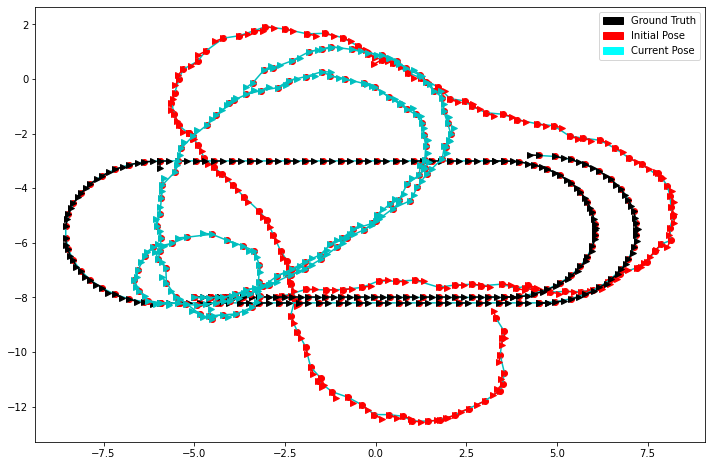

The error value for interation  31  came out to be :  0.9670115 

The error value for interation  32  came out to be :  0.96668553 

The error value for interation  33  came out to be :  0.9665662 

The error value for interation  34  came out to be :  0.9665195 

The error value for interation  35  came out to be :  0.9665008 

The error value for interation  36  came out to be :  0.96649265 

The error value for interation  37  came out to be :  0.96648854 

The error value for interation  38  came out to be :  0.9664874 

The error value for interation  39  came out to be :  0.966486 

The error value for interation  40  came out to be :  0.96648645 



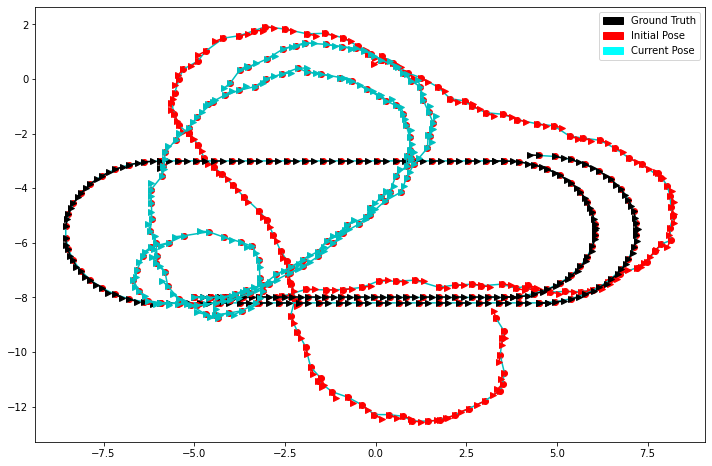

The error value for interation  41  came out to be :  0.96648586 

The error value for interation  42  came out to be :  0.96648556 

The error value for interation  43  came out to be :  0.9664855 

The error value for interation  44  came out to be :  0.9664846 

The error value for interation  45  came out to be :  0.9664864 

The error value for interation  46  came out to be :  0.96648633 

The error value for interation  47  came out to be :  0.96648574 

The error value for interation  48  came out to be :  0.9664858 

The error value for interation  49  came out to be :  0.9664856 

The error value for interation  50  came out to be :  0.9664852 



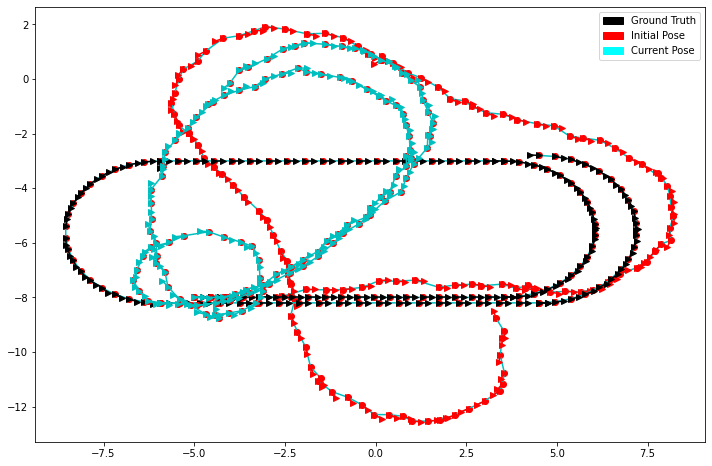

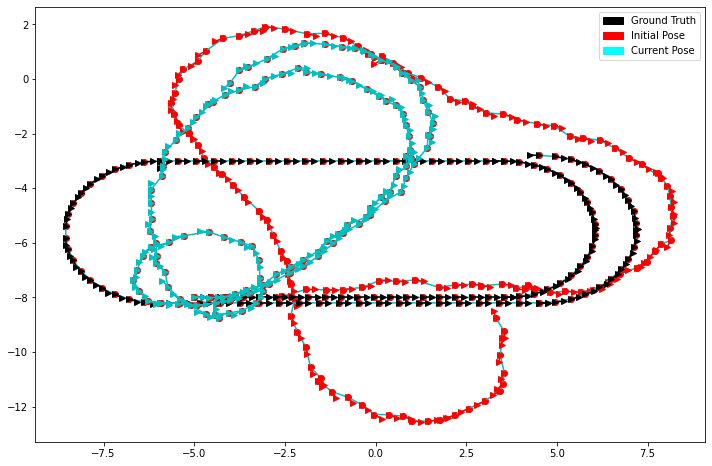

In [45]:
# Initial information values:
informationOdometry = 1
informationLoopConst = 100
informationAnchor = 100
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 50
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

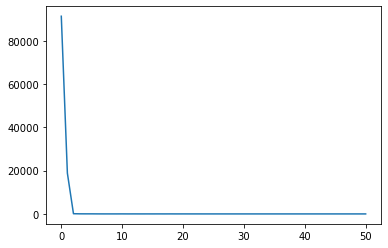

In [46]:
plt.plot(collection_errors)

### Running for information values : (100,1000,100)

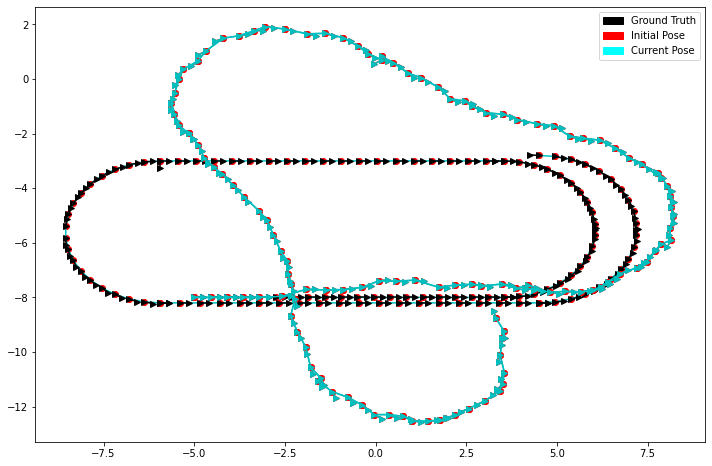

The error value for interation  1  came out to be :  115383.914 

The error value for interation  2  came out to be :  2773.5178 

The error value for interation  3  came out to be :  741.9413 

The error value for interation  4  came out to be :  470.9679 

The error value for interation  5  came out to be :  785.9921 

The error value for interation  6  came out to be :  230.53413 

The error value for interation  7  came out to be :  289.94348 

The error value for interation  8  came out to be :  199.01369 

The error value for interation  9  came out to be :  279.82108 

The error value for interation  10  came out to be :  169.27856 



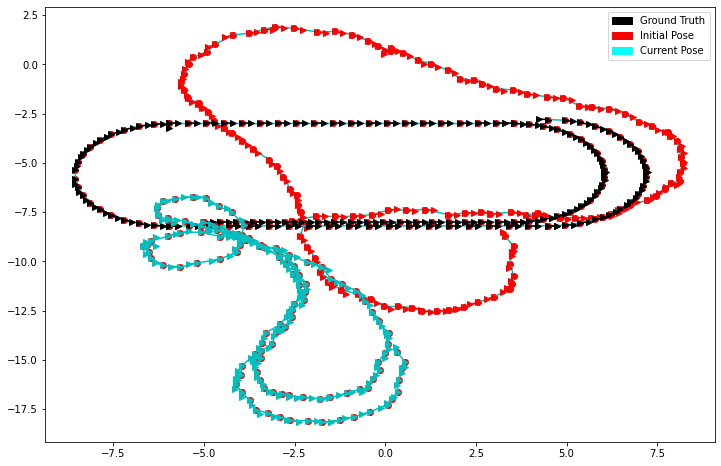

The error value for interation  11  came out to be :  237.63202 

The error value for interation  12  came out to be :  138.69827 

The error value for interation  13  came out to be :  174.66702 

The error value for interation  14  came out to be :  116.41491 

The error value for interation  15  came out to be :  126.043205 

The error value for interation  16  came out to be :  103.61699 

The error value for interation  17  came out to be :  103.51888 

The error value for interation  18  came out to be :  98.77861 

The error value for interation  19  came out to be :  96.62948 

The error value for interation  20  came out to be :  95.78174 



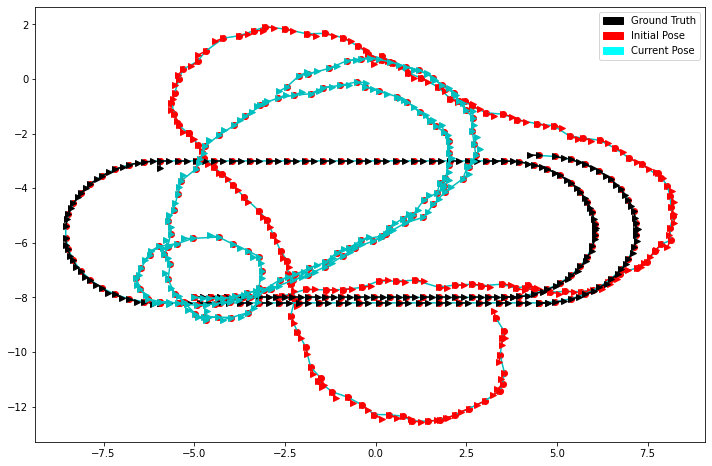

The error value for interation  21  came out to be :  95.4611 

The error value for interation  22  came out to be :  95.32972 

The error value for interation  23  came out to be :  95.27234 

The error value for interation  24  came out to be :  95.24612 

The error value for interation  25  came out to be :  95.233795 

The error value for interation  26  came out to be :  95.22799 

The error value for interation  27  came out to be :  95.22513 

The error value for interation  28  came out to be :  95.2237 

The error value for interation  29  came out to be :  95.223076 

The error value for interation  30  came out to be :  95.22278 



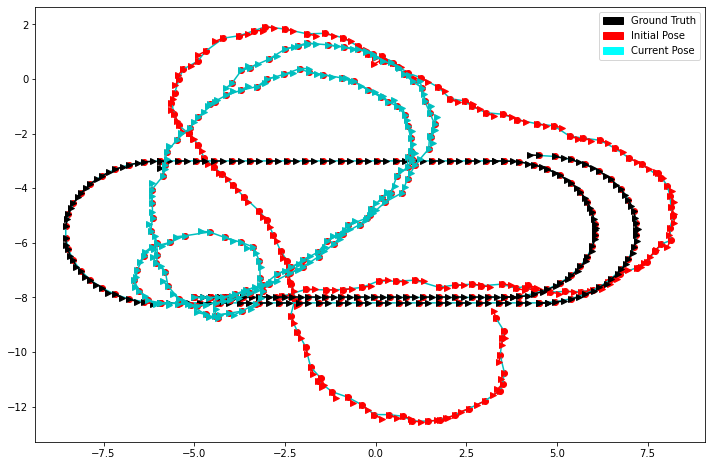

The error value for interation  31  came out to be :  95.222626 

The error value for interation  32  came out to be :  95.22259 

The error value for interation  33  came out to be :  95.222595 

The error value for interation  34  came out to be :  95.22251 

The error value for interation  35  came out to be :  95.22245 

The error value for interation  36  came out to be :  95.22251 

The error value for interation  37  came out to be :  95.22253 

The error value for interation  38  came out to be :  95.22243 

The error value for interation  39  came out to be :  95.22246 

The error value for interation  40  came out to be :  95.22244 



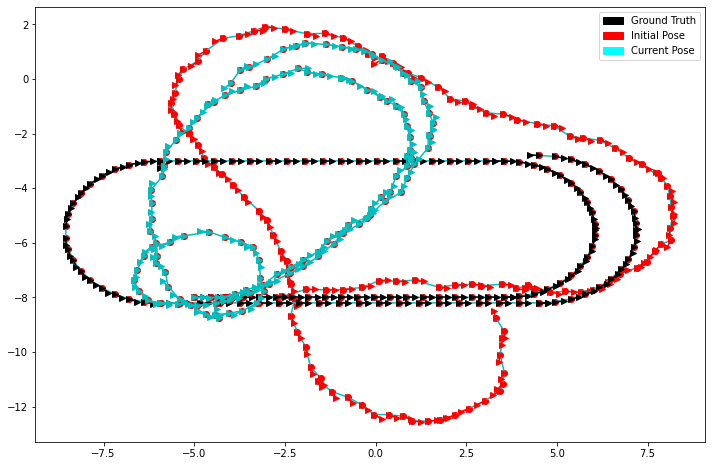

The error value for interation  41  came out to be :  95.22252 

The error value for interation  42  came out to be :  95.222534 

The error value for interation  43  came out to be :  95.222534 

The error value for interation  44  came out to be :  95.22253 

The error value for interation  45  came out to be :  95.22248 

The error value for interation  46  came out to be :  95.22251 

The error value for interation  47  came out to be :  95.22247 

The error value for interation  48  came out to be :  95.2225 

The error value for interation  49  came out to be :  95.22253 

The error value for interation  50  came out to be :  95.222496 



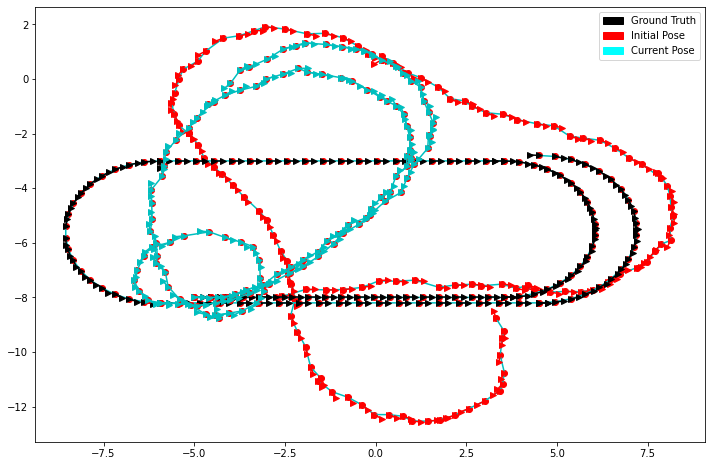

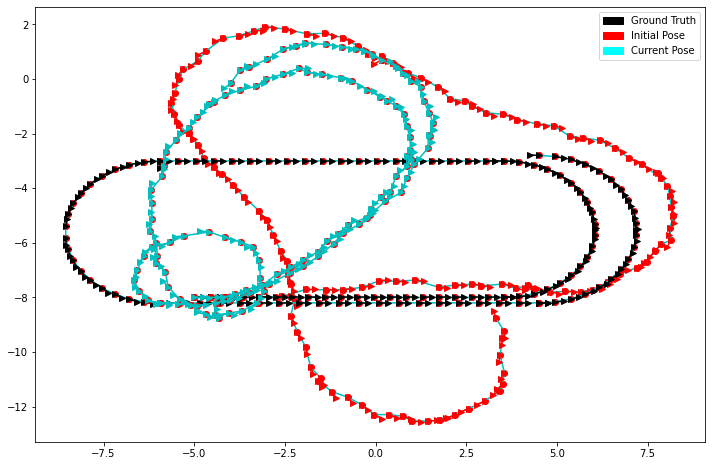

In [47]:
# Initial information values:
informationOdometry = 100
informationLoopConst = 1000
informationAnchor = 100
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 50
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

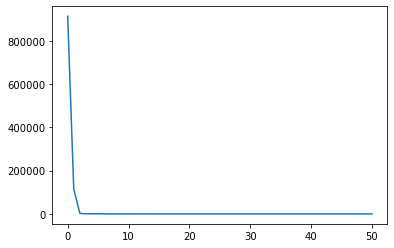

In [48]:
plt.plot(collection_errors)

### Running for information values : (1e-5,1e-3,1e-3)

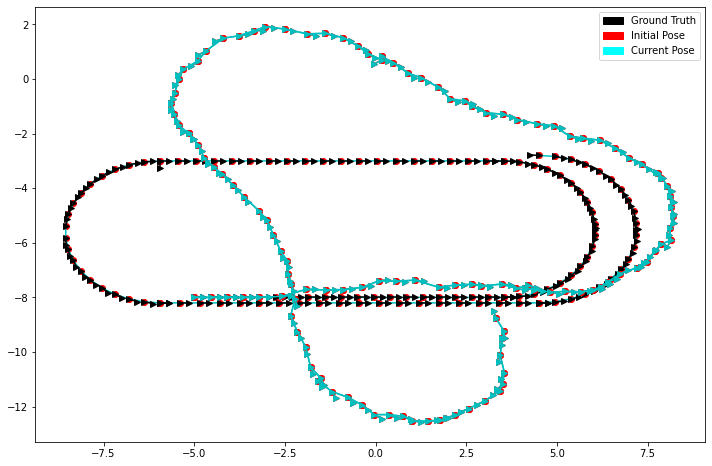

The error value for interation  1  came out to be :  0.907691 

The error value for interation  2  came out to be :  0.9020199 

The error value for interation  3  came out to be :  0.8852431 

The error value for interation  4  came out to be :  0.8370346 

The error value for interation  5  came out to be :  0.7109132 

The error value for interation  6  came out to be :  0.46660814 

The error value for interation  7  came out to be :  0.21423817 

The error value for interation  8  came out to be :  0.055280168 

The error value for interation  9  came out to be :  0.0119718565 

The error value for interation  10  came out to be :  0.006739315 



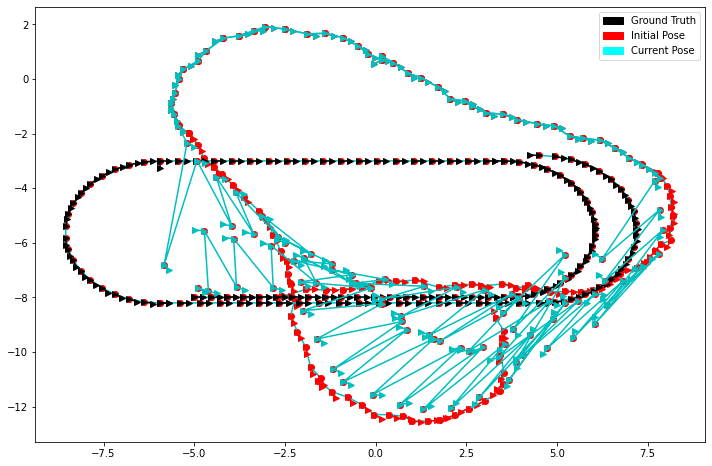

The error value for interation  11  came out to be :  0.0036622758 

The error value for interation  12  came out to be :  0.0012998346 

The error value for interation  13  came out to be :  0.0005087256 

The error value for interation  14  came out to be :  0.00033996894 

The error value for interation  15  came out to be :  0.0003991091 

The error value for interation  16  came out to be :  0.00015149267 

The error value for interation  17  came out to be :  0.00012317079 

The error value for interation  18  came out to be :  8.535001e-05 

The error value for interation  19  came out to be :  7.2514194e-05 

The error value for interation  20  came out to be :  0.00012230895 



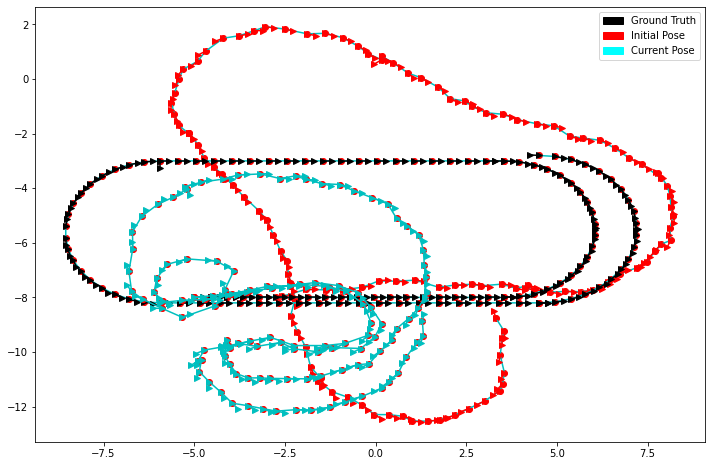

The error value for interation  21  came out to be :  3.1216558e-05 

The error value for interation  22  came out to be :  3.2178046e-05 

The error value for interation  23  came out to be :  1.6143236e-05 

The error value for interation  24  came out to be :  1.9150972e-05 

The error value for interation  25  came out to be :  1.41103565e-05 

The error value for interation  26  came out to be :  1.62836e-05 

The error value for interation  27  came out to be :  1.294463e-05 

The error value for interation  28  came out to be :  1.5591248e-05 

The error value for interation  29  came out to be :  1.2018807e-05 

The error value for interation  30  came out to be :  1.4960046e-05 



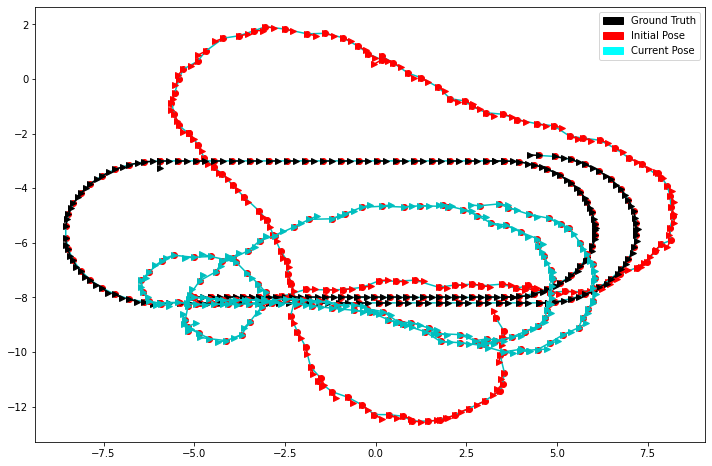

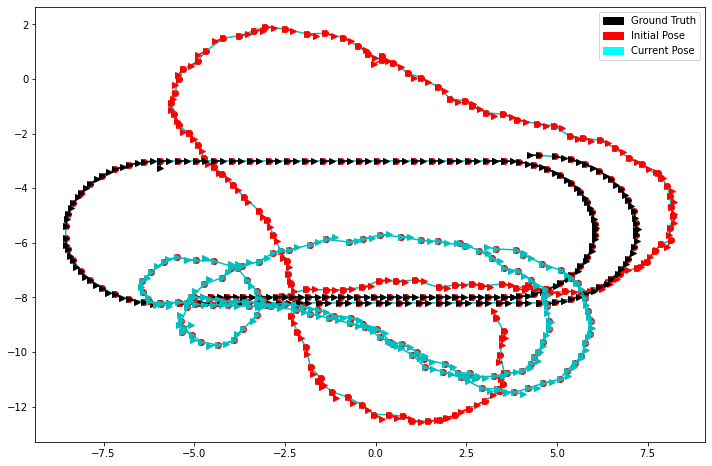

In [49]:
# Initial information values:
informationOdometry = 1e-5
informationLoopConst = 1e-3
informationAnchor = 1e-3
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 30
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

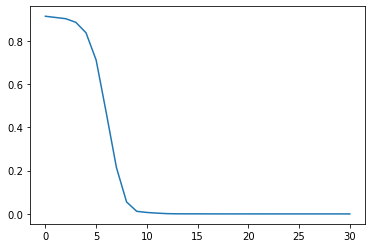

In [50]:
plt.plot(collection_errors)

### Running for information values : (1000,1,10)

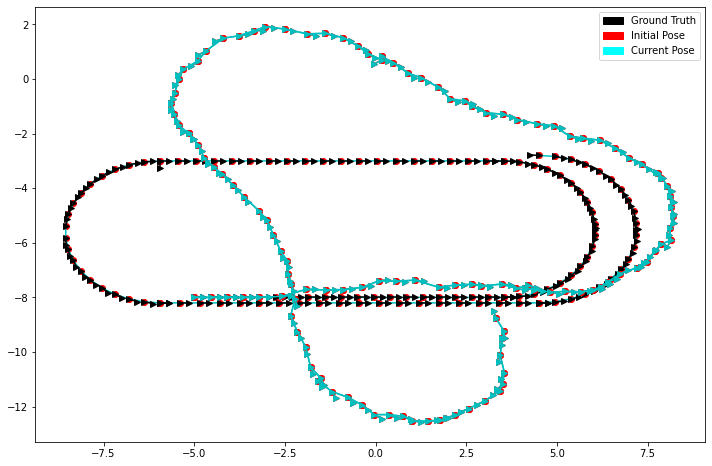

The error value for interation  1  came out to be :  592.74255 



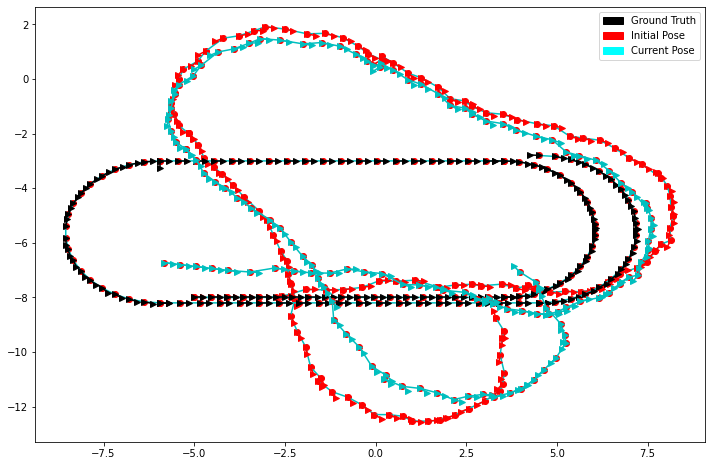

The error value for interation  2  came out to be :  491.4479 



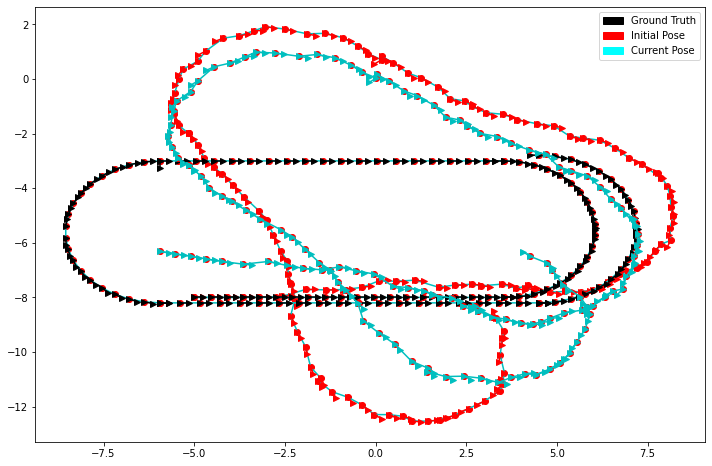

The error value for interation  3  came out to be :  438.83026 



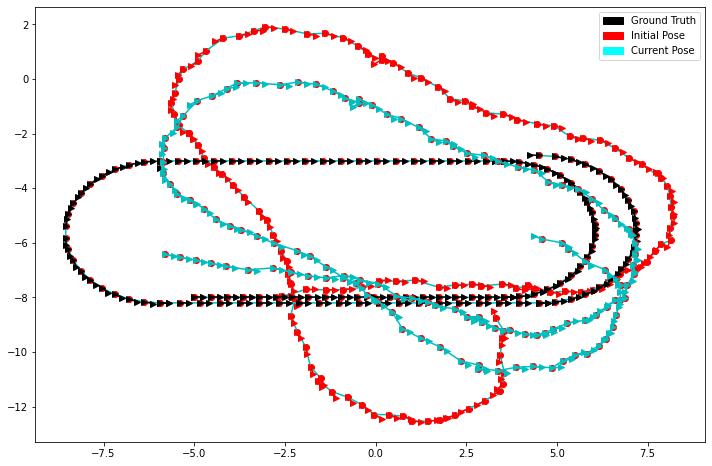

The error value for interation  4  came out to be :  409.09384 



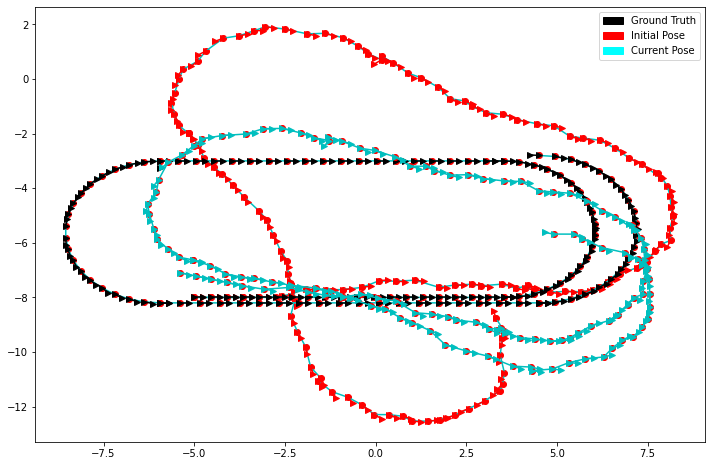

The error value for interation  5  came out to be :  394.35498 



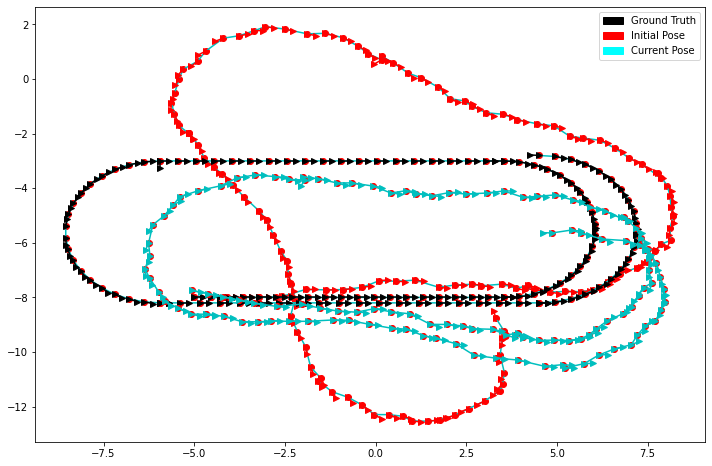

The error value for interation  6  came out to be :  388.83997 



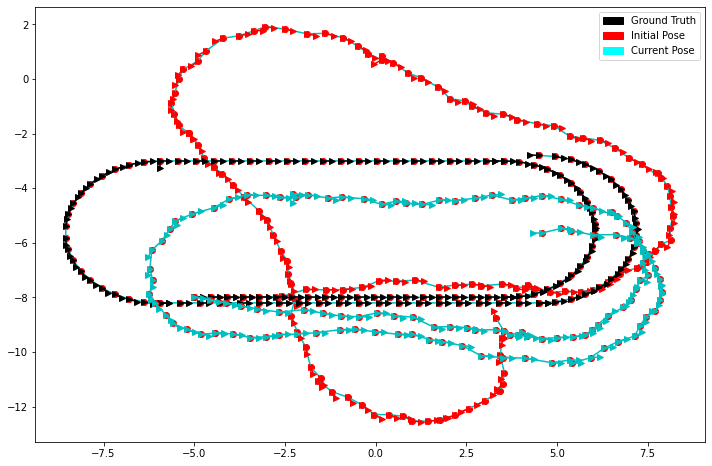

The error value for interation  7  came out to be :  388.5663 



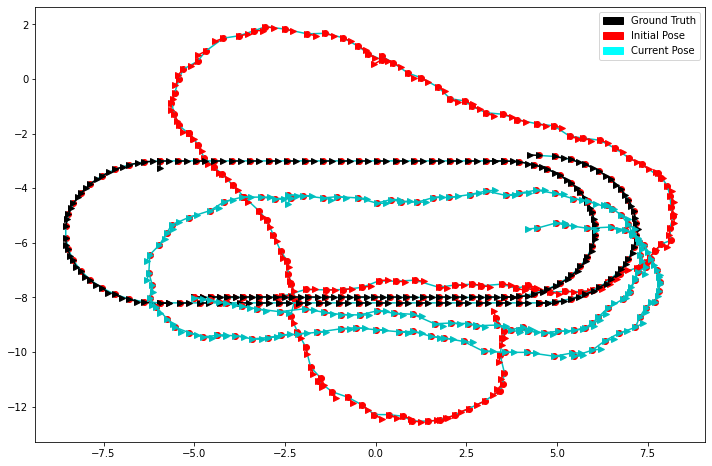

The error value for interation  8  came out to be :  388.48358 



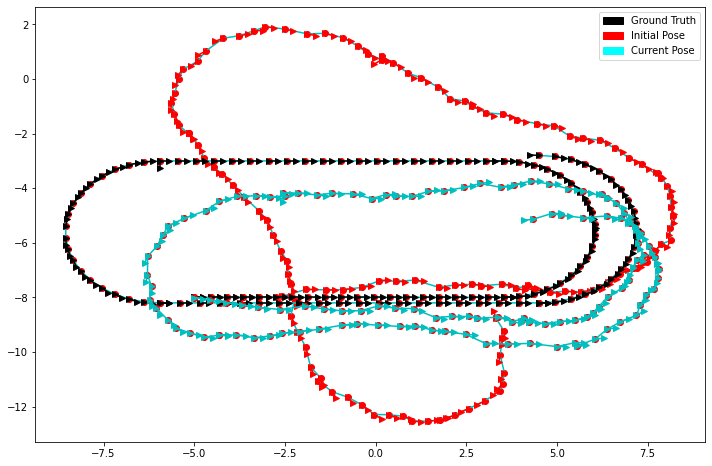

The error value for interation  9  came out to be :  388.4142 



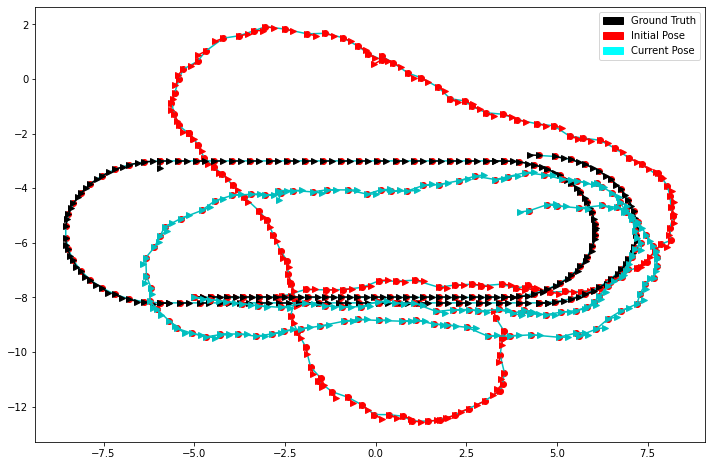

The error value for interation  10  came out to be :  388.36154 



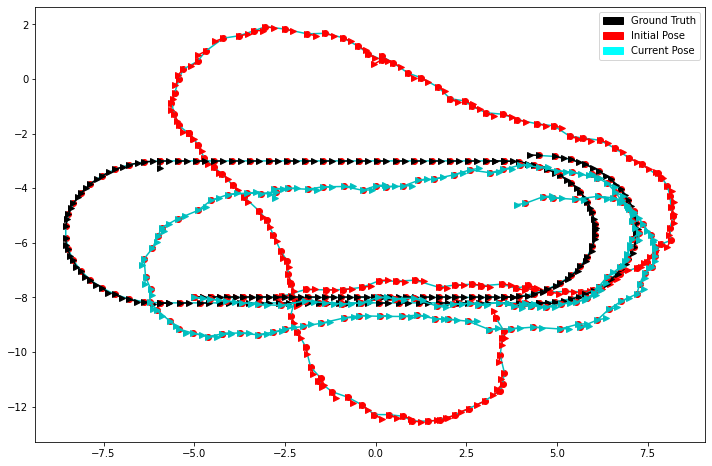

The error value for interation  11  came out to be :  388.32315 



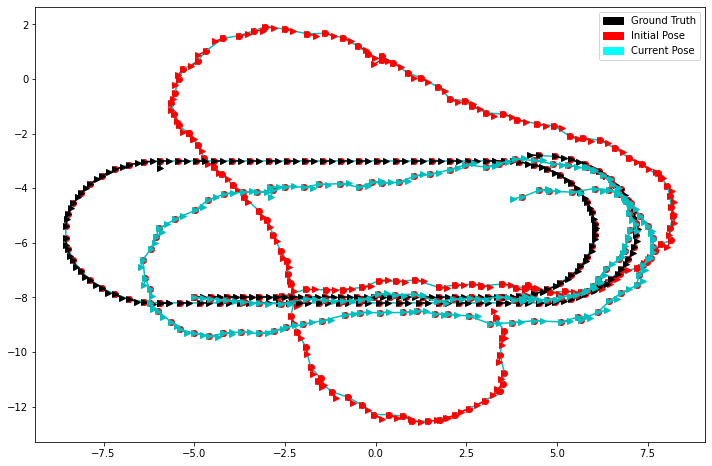

The error value for interation  12  came out to be :  388.2963 



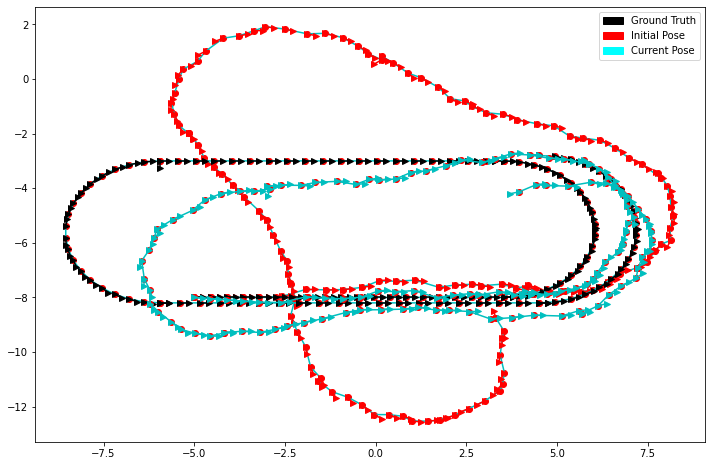

The error value for interation  13  came out to be :  388.27737 



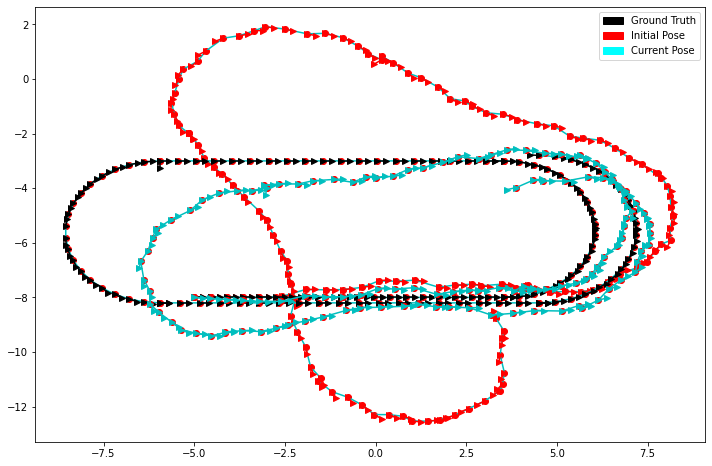

The error value for interation  14  came out to be :  388.26407 



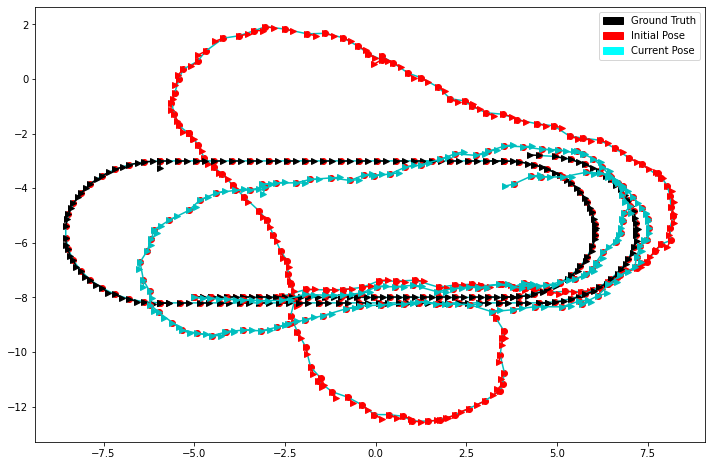

The error value for interation  15  came out to be :  388.25455 



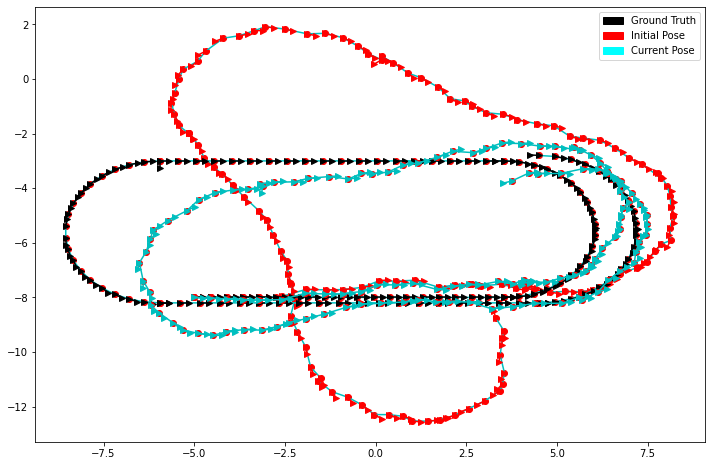

The error value for interation  16  came out to be :  388.2478 



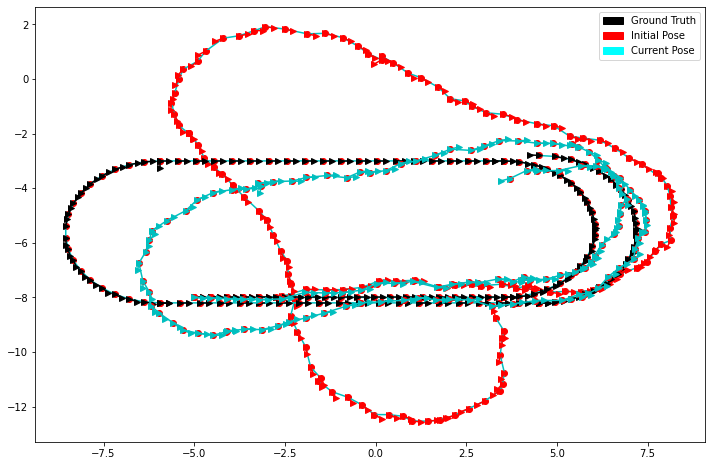

The error value for interation  17  came out to be :  388.2432 



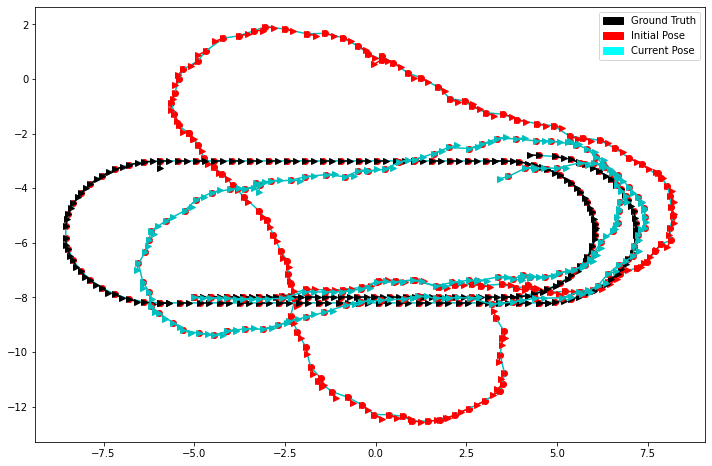

The error value for interation  18  came out to be :  388.23978 



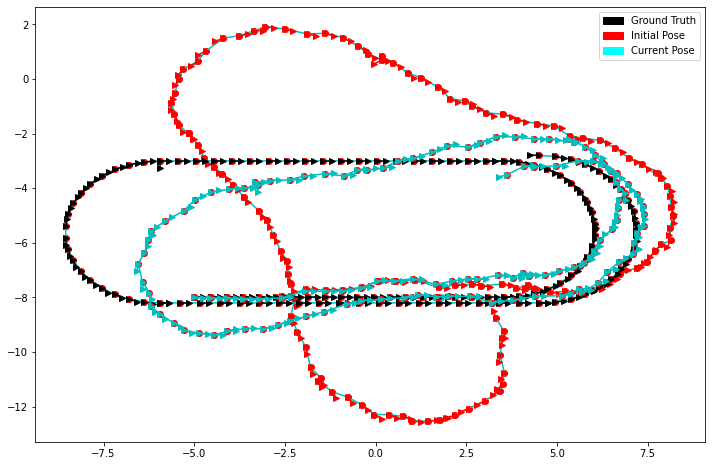

The error value for interation  19  came out to be :  388.23746 



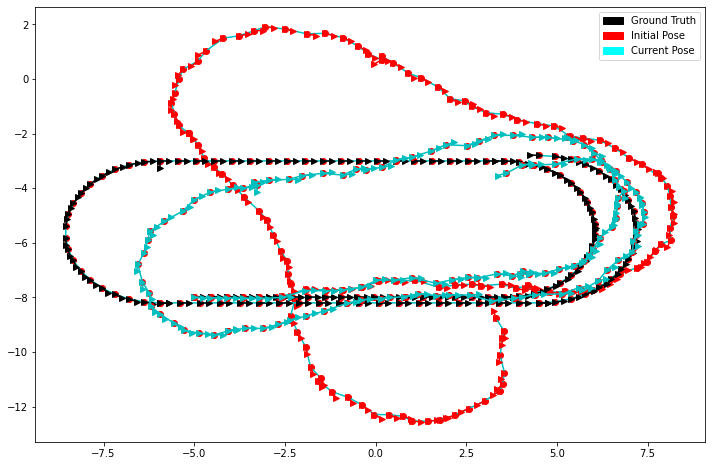

The error value for interation  20  came out to be :  388.23575 



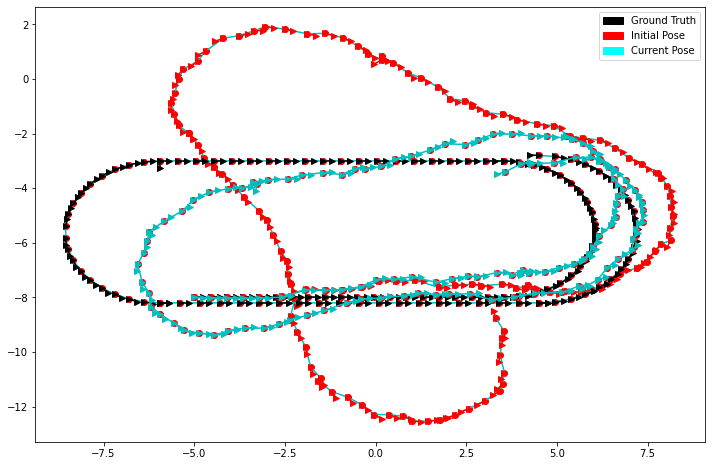

The error value for interation  21  came out to be :  388.2346 



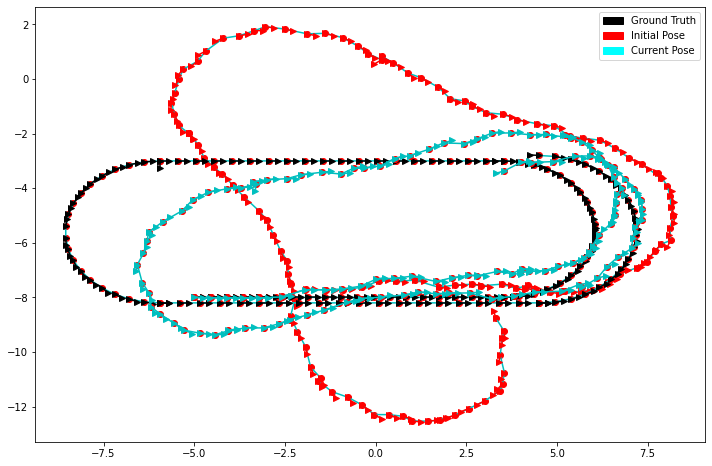

The error value for interation  22  came out to be :  388.23383 



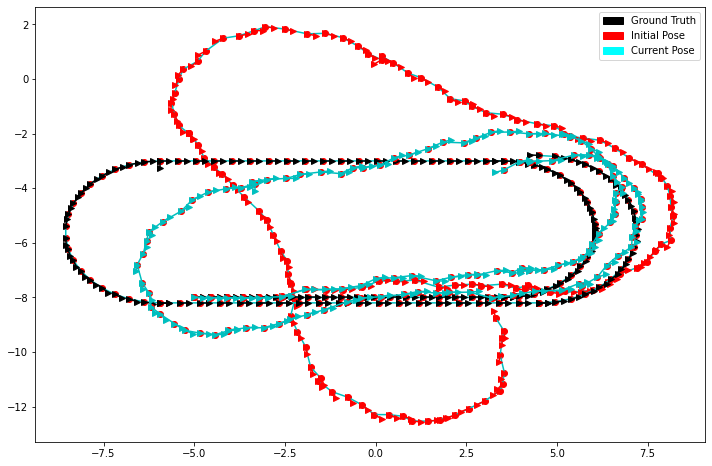

The error value for interation  23  came out to be :  388.23312 



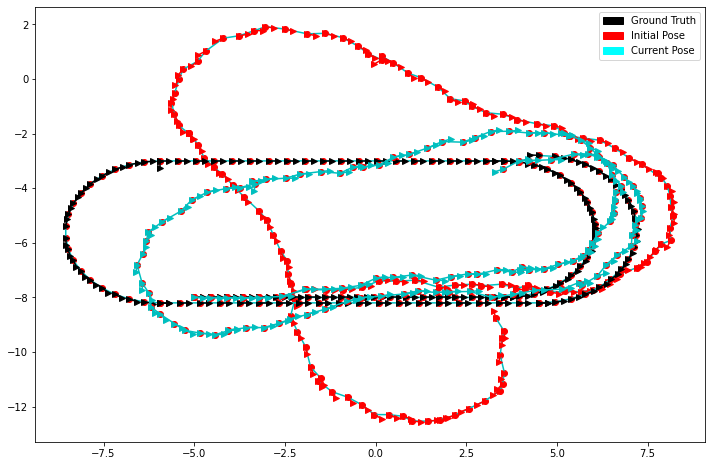

The error value for interation  24  came out to be :  388.2328 



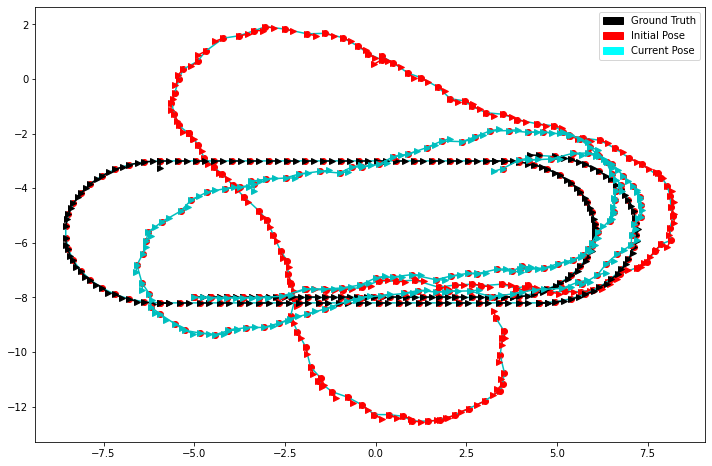

The error value for interation  25  came out to be :  388.23242 



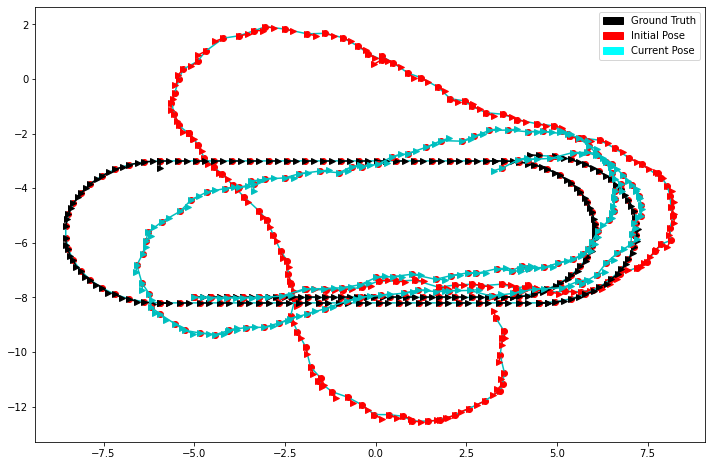

The error value for interation  26  came out to be :  388.23224 



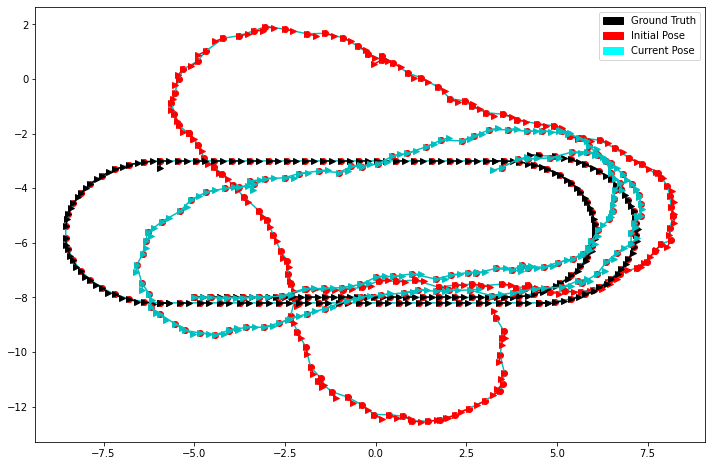

The error value for interation  27  came out to be :  388.23212 



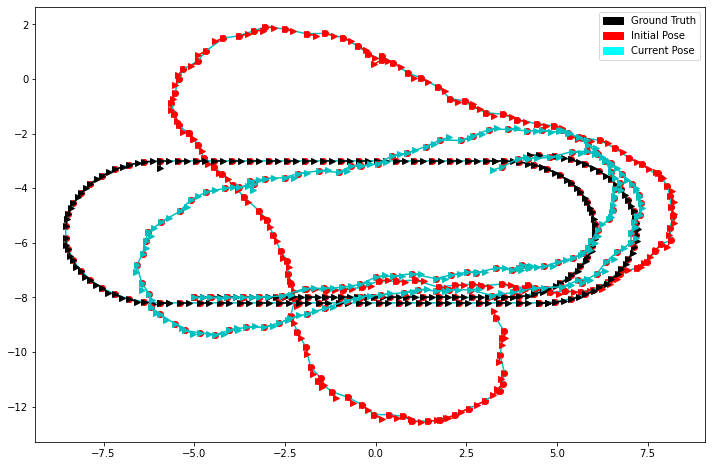

The error value for interation  28  came out to be :  388.23193 



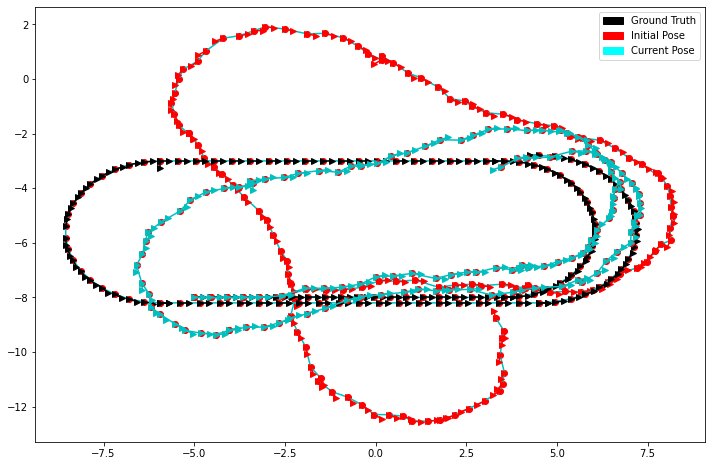

The error value for interation  29  came out to be :  388.23178 



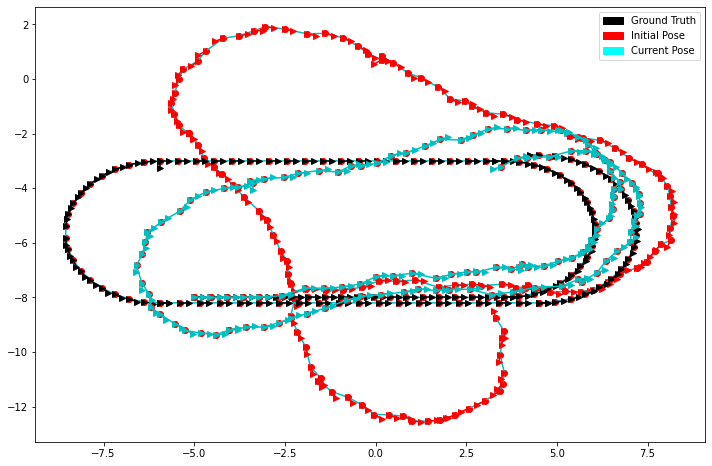

The error value for interation  30  came out to be :  388.2318 



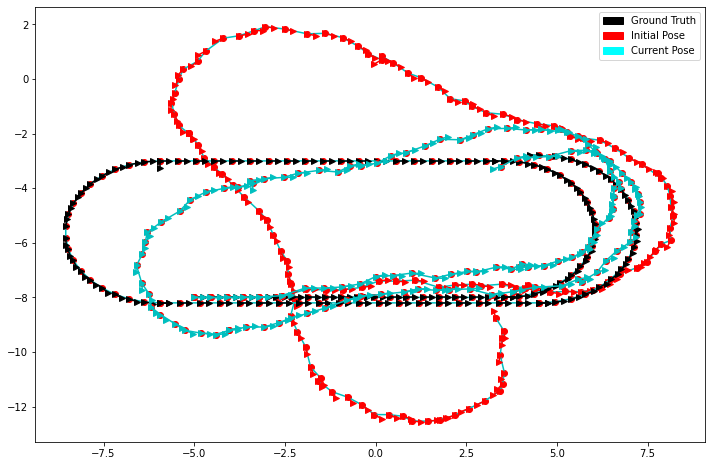

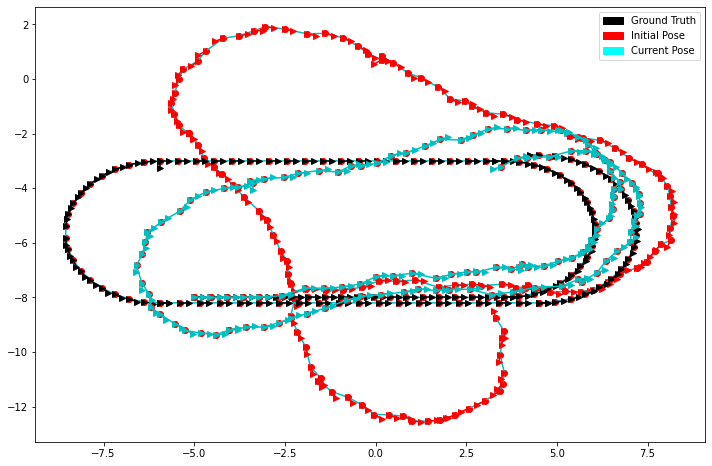

In [56]:
# Initial information values:
informationOdometry = 1000
informationLoopConst = 1
informationAnchor = 10
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 30
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:

lm_lambda = 1

draw_all(poses[:, 0], poses[:,1],poses[:,2])
collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

## Observation:

# Table

The information values are in the order : (weight of odometry edge, weight of loop-constraint edge, weight of anchor edge)
| Information Values      | Final Error (converging value) | Number of Iterations|
| :---        |    :----:   |  ---:   |
|  (10,1000,1000)    | 9.666   | 30 |
| (1,10,10)   |     0.966    |50|
|(500,700,1000)|444|50|
|(600,20,10)|2987.4|50|
|(100,1000,100)|95.22|50|
|(1e-5,1e-3,1e-3)|1.4 * 1e-5|30|

<br>

Here we can observe that: When values of Information matrix are scaled by s, the error increases by s and vice versa.
By the definition of our algoritm(error = f(x).T @ InformationMatrix @ f(x)) , it is not optimal to base and compare our observations on this erorr. This is because the error is dependent on information matrix, so we can go on reducing all the input values by some factor to get smaller error values correspondingly.    
That's why we use APE and RPE in evo as done in next part.

We also observe here that the odometry values given to us are more reliable and correct as compared to the loop-constraint, as we can see from the above plots. This is not something that generally holds true, as we usually tend to rely on loop-constraints.`

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

1. The residual's structures is given below:    
   
![Theory](../misc/Q3-images/residual.jpeg "Residual")

The residual consists of error in estimation using odometry and loop constraints. It stores the error in x_i,y_i and theta_i themselves stretched as 3 rows. 
Let's assume number of odometry+loop constraints = e, so number of rows in residual = 3*e .
But since it also contains anchor point, so total number of rows in residual = 3*e+3.

Shape: (3e+3) x 1


The Jacobian's structure is given below:     
   

![Theory](../misc/Q3-images/jacobian.jpeg "Jacobian")

Each column of Jacobian is the partial derivative of residual with respect to frame. It does so by computing partial derivatives w.r.t. x_i,y_i and theta_i and them stretching them as three columns. So let the number of frames = v. 
So dimension of jacobian = (3*e+3) x 3*v

2. The optimization process is highly nonlinear and hence requires the LM algorithm. The output of this algorithm depends on the initial values/constraints, the initial lambda used for LM, and the information matrix. The initial values are already given, and the initial lambda for LM is taken here as 1. But the ultimate factor for determining the optimality of the solution is undoubtedly the information matrix. The information matrix has 3 different entities. The odometry information defines how much we trust the consecutive edges (i.e., the odometry) which usually obtained from the ICP algorithms and is highly susceptible to depth noises and correspondences, hence the weight given to it is usually the smallest of the three. The second is the loop closure information, which is our main focus and essesntially why we are performing this optimization and hence the weight given to it is usually high. The last one is the anchor edge information which is essentially how much we trust our initial position given to us by the odomentry. In order to make sure that our optimization doesn't deviate much from the initial position given to it, we attach a very strong edge between the initial position and the initial position vertex.
It is can also be observed that at each iteration of LM, we try to calculate the jacobian for the new iteration which we do by caculating it from scratch. This overhead can be reduced by only changing certain locations of the old jacobian matrix instead of making an entirely new one. From the analytical jacobian matrix we can see that most part of the jacobian matrix remains constant, the only part which changes depends on the theta values, which is roughly less than 10% of the jacobian. This will increase the speed of calculating the new jacobian 10 times.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [51]:
bestPoses = collection_poses[optimal_index]
#Now we will create and save the file edges-poses-optimised.txt
posesString = poses_to_string(bestPoses)

#First deleting any previous occurence of the file
os.system('rm ../data/edges-poses-optimised.txt')

#After creating edges-poses.txt, append poses info to it.
for i in posesString:
    file_object = open("../data/edges-poses-optimised.txt", 'a')
    file_object.write(i)
    file_object.write('\n')
file_object.close()

#Now open and read edges.txt file (and ignore the initial VERTEX_SE2 row), then append edges.txt to edges-pose.txt
with open("../data/edges.txt", "r") as f:
    lines = f.readlines()
with open("../data/edges-poses-optimised.txt","a") as f:
    for line in lines:
        if line.strip("\n") != "VERTEX_SE2 0 -5.0 -8.0 0.0":
            f.write(line)

#Converting to g2o file
os.system('cp ../data/edges-poses-optimised.txt ../data/edges-poses-optimised.g2o')

0